In [2]:
# --- Section 0: Parameters --------------------------------

import numpy as np
from tqdm.auto import tqdm

# Core parameters

N      = 1000      # number of disks
sigma  = 1.0      # disk radius (contact distance = 2*sigma)
Lx     = 64.0     # box size in x
Ly     = 64.0     # box size in y
T      = 10.0      # temperature (k_B = 1 units)
m      = 1.0      # particle mass (relevant if gravity is used)
g      = 0.0      # gravity along +y; set > 0 to enable
seed   = 1234     # random seed for reproducibility
boundary = "periodic"  # "periodic" or "closed"

# Derived-quantity helpers
def area(Lx: float, Ly: float) -> float:
    return Lx * Ly

def packing_fraction(N: int, sigma: float, Lx: float, Ly: float) -> float:
    return N * np.pi * sigma**2 / (Lx * Ly)

def beta(T: float) -> float:
    return 1.0 / T

def sedimentation_length(T: float, m: float, g: float) -> float:
    """k_B T / (m g); returns np.inf if g == 0 (k_B = 1)."""
    return np.inf if g == 0.0 else T / (m * g)

# Evaluate

AREA = area(Lx, Ly)
PHI  = packing_fraction(N, sigma, Lx, Ly)
BETA = beta(T)
ELL  = sedimentation_length(T, m, g)

# RNG
rng = np.random.default_rng(seed)

# Quick report
print(f"System size: Lx={Lx}, Ly={Ly}, area={AREA}")
print(f"N={N}, sigma={sigma}, contact distance={2*sigma}")
print(f"Packing fraction phi = {PHI:.4f}")
print(f"Temperature T={T}, beta={BETA:.3f}")
print(f"Gravity g={g}, sedimentation length (if g>0) = {ELL}")
print(f"Boundary condition: {boundary}")

C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


System size: Lx=64.0, Ly=64.0, area=4096.0
N=1000, sigma=1.0, contact distance=2.0
Packing fraction phi = 0.7670
Temperature T=10.0, beta=0.100
Gravity g=0.0, sedimentation length (if g>0) = inf
Boundary condition: periodic


In [3]:
# --- MC simulation  ----------------------------

# ---------- Tiny geometry helpers ----------
def wrap_pbc(r):  # r: (...,2)
    "Keep positions inside the primary periodic box [0,Lx) *[0,Ly)"
    out = np.empty_like(r, dtype=float)  # Empty output array with the same dimensions as r
    out[..., 0] = np.mod(r[..., 0], Lx)  # Maps any real x to the interval [0, Lx)
    out[..., 1] = np.mod(r[..., 1], Ly)  # Maps any real x to the interval [0, Ly)
    return out

def minimum_image_disp(ri, rj):
    "Compute the displacement vector from particle i to j using the minimum-image convention: "
    "under PBC you should always measure distance across the nearest image "
    "(possibly through a boundary) to avoid spurious long distances."
    dx = rj[0] - ri[0]
    dy = rj[1] - ri[1]
    dx -= Lx * np.rint(dx / Lx)  #np.rint() Round elements of the array to the nearest integer
    dy -= Ly * np.rint(dy / Ly)
    return np.array([dx, dy], dtype=float)

def dist2_pbc(ri, rj):
    "Compute the squared distance between two points under PBC"
    d = minimum_image_disp(ri, rj)
    return float(d[0]*d[0] + d[1]*d[1])

def inside_walls(r):
    "Boolan; True: disk is inside the walls; False: disk's edge is stepping outisde the walls"
    return (sigma <= r[0] <= Lx - sigma) and (sigma <= r[1] <= Ly - sigma)


# ------------ Overlapping and initialization -----------

def has_overlap_with_any(i, r_trial, pos, periodic=True):
    "Given a candidate position for particle i, decide if it would overlap any already-placed disk."
    contact2 = (2.0 * sigma)**2
    M = pos.shape[0]
    for j in range(M):
        if j == i: 
            continue
        if not np.all(np.isfinite(pos[j])): 
            continue
        d2 = dist2_pbc(r_trial, pos[j]) if periodic else float(((r_trial - pos[j])**2).sum())
        if d2 < contact2:
            return True
    return False

def init_positions_random():
    "Place N disks randomly without overlaps via rejection sampling."
    periodic = (boundary == "periodic")
    positions = np.full((N, 2), np.nan, dtype=float)   #allocate an array for centers; mark as NaN until placed.
    for i in range(N):
        for _ in range(20000):
            if periodic:
                # Periodic: Anywhere inside the walls
                r_trial = np.array([rng.uniform(0, Lx), rng.uniform(0, Ly)], dtype=float)
            else:
                # Closed: Respect wall distance sigma
                r_trial = np.array([rng.uniform(sigma, Lx - sigma),
                                    rng.uniform(sigma, Ly - sigma)], dtype=float)
            if i == 0 or not has_overlap_with_any(i, r_trial, positions[:i], periodic=periodic):
                positions[i] = r_trial
                break
        else:
            raise RuntimeError("Could not place particle—reduce PHI or enlarge box.")
    return positions

# ---------- MC step ----------

def propose_displacement(delta):
    "Create a small random 2D displacement for a trial move. Uniform in a square - zero mean"
    "rng.random(2) → two independent uniform samples in [0,1)"
    "- 0.5 centers them in  [-0.5,0.5) "
    return delta * (rng.random(2) - 0.5)  

def attempt_move(i, pos, pos_u, delta):
    """
    pos   : wrapped positions (in-box)
    pos_u : unwrapped positions (for MSD)
    returns: accepted(bool)
    """
    periodic = (boundary == "periodic")
    r_old = pos[i].copy()
    du = propose_displacement(delta)
    r_trial_u = pos_u[i] + du               # unwrapped trial
    r_trial   = r_old + du                  # wrapped candidate
    if periodic:
        r_trial = wrap_pbc(r_trial)
    else:
        if not inside_walls(r_trial):
            return False

    # overlap check in the geometry we're using
    if has_overlap_with_any(i, r_trial, pos, periodic=(boundary=="periodic")):
        return False

    # external energy (gravity) — only y matters
    dE = m * g * (r_trial_u[1] - pos_u[i][1])
    if dE > 0.0 and rng.random() > np.exp(-beta(T) * dE):
        return False

    # accept: update both wrapped and unwrapped
    pos[i]   = r_trial
    pos_u[i] = r_trial_u
    return True

def mc_step(pos, pos_u, delta):
    """One Monte Carlo step = N attempted single-particle moves."""
    acc = 0  # Counter for accepted moves
    for _ in range(N):        
        i = rng.integers(0, N)                        # Pick a random particle
        acc += attempt_move(i, pos, pos_u, delta)     # True counts as 1, False as 0
    return acc / N

# ---------- Observables ----------
def msd(pos_u, pos_u0):
    disp = pos_u - pos_u0
    return float((disp**2).sum(axis=1).mean())

# ---------- Simulation ----------
def run_sim(n_steps=2000, delta=sigma/10, sample_every=10, return_traj=False):
    """
    n_steps: number of MC steps (each is N trial moves)
    delta  : proposal step size (in same units as sigma)
    sample_every: measure MSD every k steps
    """
    pos   = init_positions_random()         # wrapped
    pos_u = pos.copy()                      # unwrapped reference
    pos_u0 = pos_u.copy()

    times, msds, accs = [], [], []
    traj = [] if return_traj else None

    for t in tqdm(range(1, n_steps + 1), desc="Sim", unit="step"):
        acc = mc_step(pos, pos_u, delta)
        if t % sample_every == 0:
            times.append(t)
            msds.append(msd(pos_u, pos_u0))
            accs.append(acc)
            if return_traj:
                traj.append(pos.copy())

    out = {"t": np.array(times), "msd": np.array(msds), "acc": np.array(accs)}
    if return_traj:
        out["traj"] = np.array(traj)  # shape: (samples, N, 2)
    return out

In [35]:
# ---------- Demo run ----------
# Example: low density, periodic, no gravity
res = run_sim(n_steps=1000, delta=sigma/10, sample_every=1)
print(f"Collected {len(res['t'])} samples. Mean acceptance ~ {np.mean(res['acc']):.3f}")

Sim:   0%|          | 2/1000 [00:34<4:44:50, 17.12s/step]


KeyboardInterrupt: 

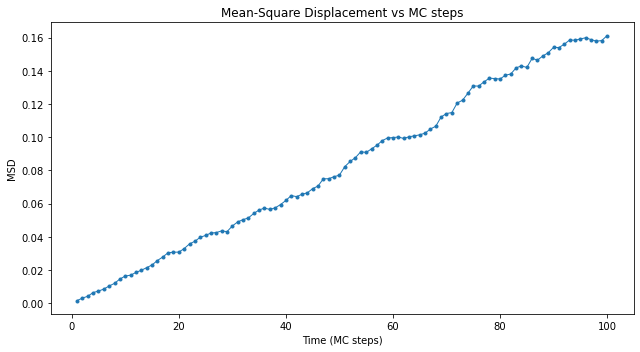

In [10]:
# --- Plot MSD vs Monte Carlo step ---
import matplotlib.pyplot as plt

t = res["t"]      # time in Monte Carlo steps (MCs)
msd_vals = res["msd"]

plt.figure(figsize=(9, 5))
plt.plot(t, msd_vals, marker="o", linestyle="-", linewidth=1, markersize=3)
plt.xlabel("Time (MC steps)")
plt.ylabel("MSD")
plt.title("Mean-Square Displacement vs MC steps")
plt.tight_layout()
plt.show()

In [4]:
# --------- FAST OVERLAP: uniform grid (linked-cell) + MC loop with incremental updates ---------
import numpy as np

class NeighborGrid:
    """
    Periodic uniform grid; cell size >= contact distance ensures only 3x3 cells to check.
    Maintains lists of particle indices per cell and updates incrementally on accepted moves.
    """
    def __init__(self, Lx, Ly, sigma):
        self.Lx, self.Ly = float(Lx), float(Ly)
        self.contact = 2.0 * sigma
        self.cs = self.contact * 1.01
        self.ncx = max(3, int(np.floor(self.Lx / self.cs)))
        self.ncy = max(3, int(np.floor(self.Ly / self.cs)))
        self.csx = self.Lx / self.ncx
        self.csy = self.Ly / self.ncy
        self.cells = None
        self.where = None  # integer pairs (ix,iy) for each particle; (-1,-1) if not added yet

    def _cell_of(self, r):
        ix = int(np.floor(r[0] / self.csx)) % self.ncx
        iy = int(np.floor(r[1] / self.csy)) % self.ncy
        return ix, iy

    def init_empty(self, N):
        """Prepare empty cell lists and where-table for N particles (none added yet)."""
        self.cells = [[[] for _ in range(self.ncy)] for _ in range(self.ncx)]
        self.where = np.full((N, 2), -1, dtype=int)

    def add_particle(self, i, r):
        """Register a particle that did not exist in the grid yet."""
        ix, iy = self._cell_of(r)
        self.cells[ix][iy].append(i)
        self.where[i] = (ix, iy)

    def neighbors_indices(self, r):
        """Iterate particle indices in the 3x3 neighborhood around r's cell."""
        ix, iy = self._cell_of(r)
        for dx in (-1, 0, 1):
            cx = (ix + dx) % self.ncx
            for dy in (-1, 0, 1):
                cy = (iy + dy) % self.ncy
                yield from self.cells[cx][cy]

    def move_particle(self, i, r_old, r_new):
        """Update lists when particle i (already registered) moves cell."""
        ix_old, iy_old = self.where[i]
        if ix_old < 0:           # not in grid yet (safety net)
            self.add_particle(i, r_new)
            return
        ix_new, iy_new = self._cell_of(r_new)
        if (ix_new != ix_old) or (iy_new != iy_old):
            # remove from old cell (swap&pop)
            cell_list = self.cells[ix_old][iy_old]
            j = cell_list.index(i)
            cell_list[j], cell_list[-1] = cell_list[-1], cell_list[j]
            cell_list.pop()
            # add to new cell
            self.cells[ix_new][iy_new].append(i)
            self.where[i] = (ix_new, iy_new)


# --- minimum-image utilities (unchanged) ---
def minimum_image_disp(ri, rj):
    dx = rj[0] - ri[0]; dy = rj[1] - ri[1]
    dx -= Lx * np.rint(dx / Lx); dy -= Ly * np.rint(dy / Ly)
    return np.array([dx, dy], dtype=float)

def dist2_pbc(ri, rj):
    d = minimum_image_disp(ri, rj)
    return float(d[0]*d[0] + d[1]*d[1])

# --- fast overlap using the grid ---
def has_overlap_fast(i, r_trial, pos, grid, contact2):
    for j in grid.neighbors_indices(r_trial):
        if j == i:
            continue
        if not np.isfinite(pos[j,0]):  # not placed yet (during init)
            continue
        if dist2_pbc(r_trial, pos[j]) < contact2:
            return True
    return False

# --- fast initializer (still rejection, but uses grid to cut checks) ---
def init_positions_random_fast():
    periodic = (boundary == "periodic")
    positions = np.full((N, 2), np.nan, dtype=float)

    grid = NeighborGrid(Lx, Ly, sigma)
    grid.init_empty(N)  # <-- prepare empty registry for all N particles

    contact2 = (2.0 * sigma)**2
    placed = 0
    attempts_cap = 20000

    while placed < N:
        for _ in range(attempts_cap):
            r_trial = (np.array([rng.uniform(0, Lx), rng.uniform(0, Ly)], dtype=float)
                       if periodic else
                       np.array([rng.uniform(sigma, Lx - sigma),
                                 rng.uniform(sigma, Ly - sigma)], dtype=float))
            # Only check against already-placed ones (the grid holds just those)
            if placed == 0 or not has_overlap_fast(placed, r_trial, positions, grid, contact2):
                positions[placed] = r_trial
                grid.add_particle(placed, r_trial)   # <-- register freshly placed particle
                placed += 1
                break
        else:
            raise RuntimeError("Could not place particle—reduce PHI or enlarge box.")
    return positions, grid

# --- fast MC step that updates the grid incrementally ---
def mc_step_fast(pos, pos_u, delta, grid):
    acc = 0
    contact2 = (2*sigma)**2
    for _ in range(N):
        i = rng.integers(0, N)
        r_old = pos[i].copy()
        du = delta * (rng.random(2) - 0.5)
        r_trial_u = pos_u[i] + du
        r_trial = r_old + du
        if boundary == "periodic":
            r_trial = wrap_pbc(r_trial)
        else:
            if not inside_walls(r_trial):
                continue
        # fast overlap
        if has_overlap_fast(i, r_trial, pos, grid, contact2):
            continue
        # gravity (usually g=0)
        dE = m * g * (r_trial_u[1] - pos_u[i][1])
        if dE > 0.0 and rng.random() > np.exp(-beta(T) * dE):
            continue
        # accept
        pos[i] = r_trial
        pos_u[i] = r_trial_u
        grid.move_particle(i, r_old, r_trial)
        acc += 1
    return acc / N

# --- fast run wrapper mirroring your API ---
def run_sim_fast(n_steps=2000, delta=sigma/10, sample_every=10, return_traj=False):
    pos, grid = init_positions_random_fast()
    pos_u = pos.copy()
    pos_u0 = pos_u.copy()

    times, msds, accs = [], [], []
    traj = [] if return_traj else None

    for t in tqdm(range(1, n_steps + 1), desc="Sim", unit="step"):
        i = 0
        print("abans:", pos[i], pos_u[i])
        acc = mc_step_fast(pos, pos_u, delta, grid)
        print("després:", pos[i], pos_u[i])
        
        if t % sample_every == 0:
            times.append(t)
            disp = pos_u - pos_u0
            msds.append(float((disp**2).sum(axis=1).mean()))
            accs.append(acc)
            if return_traj:
                traj.append(pos.copy())

    out = {"t": np.array(times), "msd": np.array(msds), "acc": np.array(accs)}
    if return_traj:
        out["traj"] = np.array(traj)
    return out


In [20]:
# === Q1: Compute & Save ======================================================
import os
import numpy as np

# ---- Inputs / controls ------------------------------------------------------
phi_target = 0.05
deltas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]

n_steps = 1000          # MC sweeps (each ≈ N trial moves)
sample_every = 1       # record MSD every k sweeps
seed = 1234             # RNG seed so runs are comparable
rng = np.random.default_rng(seed)  # ensure global rng (used by run_sim_fast) is reset

# ---- Resize box to reach target phi (square box) ----------------------------
# phi = N * π * σ^2 / (4 Lx Ly)  -> Lx=Ly=L = sqrt(N π σ^2 / (4 φ))
L_side = float(np.sqrt(N * np.pi * sigma**2 / (phi_target)))
Lx = Ly = L_side  # update globals used by geometry helpers and run_sim_fast

# (optional) refresh derived helpers for logging
AREA = area(Lx, Ly)
PHI  = packing_fraction(N, sigma, Lx, Ly)
BETA = beta(T)
ELL  = sedimentation_length(T, m, g)

print(f"[Q1 setup] Lx=Ly={L_side:.3f} to achieve phi≈{PHI:.4f} (target {phi_target})")

# ---- Output paths -----------------------------------------------------------
data_dir = f"q1_phi_{str(phi_target).replace('.','p')}"
os.makedirs(data_dir, exist_ok=True)
summary_path = os.path.join(data_dir, "summary.csv")

# Write header for the summary CSV (overwrite if re-running)
with open(summary_path, "w") as f:
    f.write("delta,D_est,acc_mean,n_steps,sample_every,Lx,Ly,phi_target,N,sigma,T,g,seed\n")

# ---- Run all deltas, save time series and append to summary -----------------
for delta in deltas:
    out = run_sim_fast(n_steps=n_steps, delta=delta, sample_every=sample_every, return_traj=False)
    t = out["t"].astype(float)
    msd_arr = out["msd"].astype(float)
    acc_arr = out["acc"].astype(float)

    # D from long-time slope: MSD ≈ 4 D t in 2D (fit last half)
    n = len(t)
    fit_slice = slice(n//2, n)
    slope, intercept = np.polyfit(t[fit_slice], msd_arr[fit_slice], 1)
    D_est = slope / 4.0
    acc_mean = float(acc_arr.mean())

    # Save time series for this delta (t, msd, acc_per_sample)
    ts_file = os.path.join(data_dir, f"msd_delta_{str(delta).replace('.','p')}.txt")
    arr_to_save = np.column_stack([t, msd_arr, acc_arr])
    np.savetxt(
        ts_file, arr_to_save,
        header="t\tMSD\tacceptance_per_sample",
        fmt="%.8e", delimiter="\t"
    )

    # Append one line to the summary CSV
    with open(summary_path, "a") as f:
        f.write(f"{delta},{D_est},{acc_mean},{n_steps},{sample_every},"
                f"{Lx},{Ly},{phi_target},{N},{sigma},{T},{g},{seed}\n")

    print(f"Saved: {ts_file}")

print(f"Summary written to: {summary_path}")


[Q1 setup] Lx=Ly=250.663 to achieve phi≈0.0500 (target 0.05)


Sim:   0%|          | 0/1000 [00:00<?, ?step/s]

abans: [244.8223251   95.30093793] [244.8223251   95.30093793]


Sim:   0%|          | 3/1000 [00:00<01:59,  8.32step/s]

després: [244.82257102  95.30107358] [244.82257102  95.30107358]
abans: [244.82257102  95.30107358] [244.82257102  95.30107358]
després: [244.82257102  95.30107358] [244.82257102  95.30107358]
abans: [244.82257102  95.30107358] [244.82257102  95.30107358]
després: [244.82303885  95.30154322] [244.82303885  95.30154322]
abans: [244.82303885  95.30154322] [244.82303885  95.30154322]


Sim:   1%|          | 7/1000 [00:00<01:23, 11.89step/s]

després: [244.82334115  95.30195938] [244.82334115  95.30195938]
abans: [244.82334115  95.30195938] [244.82334115  95.30195938]
després: [244.82281547  95.30137779] [244.82281547  95.30137779]
abans: [244.82281547  95.30137779] [244.82281547  95.30137779]
després: [244.82281547  95.30137779] [244.82281547  95.30137779]
abans: [244.82281547  95.30137779] [244.82281547  95.30137779]
després: [244.82326968  95.30139435] [244.82326968  95.30139435]
abans: [244.82326968  95.30139435] [244.82326968  95.30139435]
després: [244.82278821  95.30123291] [244.82278821  95.30123291]
abans: [244.82278821  95.30123291] [244.82278821  95.30123291]


Sim:   1%|          | 9/1000 [00:01<02:01,  8.13step/s]

després: [244.8226534   95.30114685] [244.8226534   95.30114685]
abans: [244.8226534   95.30114685] [244.8226534   95.30114685]
després: [244.82270158  95.30133087] [244.82270158  95.30133087]
abans: [244.82270158  95.30133087] [244.82270158  95.30133087]
després: [244.82274951  95.30100065] [244.82274951  95.30100065]


Sim:   1%|▏         | 13/1000 [00:01<01:47,  9.17step/s]

abans: [244.82274951  95.30100065] [244.82274951  95.30100065]
després: [244.82292688  95.30087524] [244.82292688  95.30087524]
abans: [244.82292688  95.30087524] [244.82292688  95.30087524]
després: [244.82318796  95.30060402] [244.82318796  95.30060402]
abans: [244.82318796  95.30060402] [244.82318796  95.30060402]


Sim:   2%|▏         | 15/1000 [00:01<01:42,  9.60step/s]

després: [244.82318796  95.30060402] [244.82318796  95.30060402]
abans: [244.82318796  95.30060402] [244.82318796  95.30060402]
després: [244.82275249  95.29969588] [244.82275249  95.29969588]
abans: [244.82275249  95.29969588] [244.82275249  95.29969588]
després: [244.82267477  95.3001412 ] [244.82267477  95.3001412 ]
abans: [244.82267477  95.3001412 ] [244.82267477  95.3001412 ]


Sim:   2%|▏         | 19/1000 [00:01<01:28, 11.13step/s]

després: [244.82267477  95.3001412 ] [244.82267477  95.3001412 ]
abans: [244.82267477  95.3001412 ] [244.82267477  95.3001412 ]
després: [244.82281899  95.30013873] [244.82281899  95.30013873]
abans: [244.82281899  95.30013873] [244.82281899  95.30013873]
després: [244.82208192  95.30029594] [244.82208192  95.30029594]
abans: [244.82208192  95.30029594] [244.82208192  95.30029594]


Sim:   2%|▏         | 21/1000 [00:02<01:33, 10.51step/s]

després: [244.82208192  95.30029594] [244.82208192  95.30029594]
abans: [244.82208192  95.30029594] [244.82208192  95.30029594]
després: [244.82216478  95.30032974] [244.82216478  95.30032974]
abans: [244.82216478  95.30032974] [244.82216478  95.30032974]
després: [244.82216478  95.30032974] [244.82216478  95.30032974]
abans: [244.82216478  95.30032974] [244.82216478  95.30032974]


Sim:   2%|▎         | 25/1000 [00:02<01:23, 11.73step/s]

després: [244.82250527  95.30027708] [244.82250527  95.30027708]
abans: [244.82250527  95.30027708] [244.82250527  95.30027708]
després: [244.82250527  95.30027708] [244.82250527  95.30027708]
abans: [244.82250527  95.30027708] [244.82250527  95.30027708]
després: [244.82194698  95.30101305] [244.82194698  95.30101305]
abans: [244.82194698  95.30101305] [244.82194698  95.30101305]
després: [244.82194698  95.30101305] [244.82194698  95.30101305]
abans: [244.82194698  95.30101305] [244.82194698  95.30101305]


Sim:   3%|▎         | 29/1000 [00:02<01:09, 13.93step/s]

després: [244.82214363  95.30129497] [244.82214363  95.30129497]
abans: [244.82214363  95.30129497] [244.82214363  95.30129497]
després: [244.82216697  95.30152219] [244.82216697  95.30152219]
abans: [244.82216697  95.30152219] [244.82216697  95.30152219]
després: [244.82216697  95.30152219] [244.82216697  95.30152219]
abans: [244.82216697  95.30152219] [244.82216697  95.30152219]
després: [244.82216697  95.30152219] [244.82216697  95.30152219]
abans: [244.82216697  95.30152219] [244.82216697  95.30152219]
després: [244.82242379  95.30229963] [244.82242379  95.30229963]
abans: [244.82242379  95.30229963] [244.82242379  95.30229963]


Sim:   4%|▎         | 35/1000 [00:03<00:56, 17.22step/s]

després: [244.82194136  95.30231982] [244.82194136  95.30231982]
abans: [244.82194136  95.30231982] [244.82194136  95.30231982]
després: [244.82194136  95.30231982] [244.82194136  95.30231982]
abans: [244.82194136  95.30231982] [244.82194136  95.30231982]
després: [244.82192601  95.30217572] [244.82192601  95.30217572]
abans: [244.82192601  95.30217572] [244.82192601  95.30217572]
després: [244.82214762  95.30225485] [244.82214762  95.30225485]
abans: [244.82214762  95.30225485] [244.82214762  95.30225485]


Sim:   4%|▎         | 37/1000 [00:03<01:02, 15.47step/s]

després: [244.82184817  95.30274802] [244.82184817  95.30274802]
abans: [244.82184817  95.30274802] [244.82184817  95.30274802]
després: [244.82149458  95.30252388] [244.82149458  95.30252388]
abans: [244.82149458  95.30252388] [244.82149458  95.30252388]
després: [244.82178089  95.30213636] [244.82178089  95.30213636]
abans: [244.82178089  95.30213636] [244.82178089  95.30213636]


Sim:   4%|▍         | 41/1000 [00:03<01:06, 14.44step/s]

després: [244.82208074  95.30156292] [244.82208074  95.30156292]
abans: [244.82208074  95.30156292] [244.82208074  95.30156292]
després: [244.82163484  95.30190553] [244.82163484  95.30190553]
abans: [244.82163484  95.30190553] [244.82163484  95.30190553]
després: [244.82163484  95.30190553] [244.82163484  95.30190553]
abans: [244.82163484  95.30190553] [244.82163484  95.30190553]
després: [244.82196529  95.302128  ] [244.82196529  95.302128  ]
abans: [244.82196529  95.302128  ] [244.82196529  95.302128  ]


Sim:   4%|▍         | 45/1000 [00:03<01:11, 13.33step/s]

després: [244.82146553  95.30207547] [244.82146553  95.30207547]
abans: [244.82146553  95.30207547] [244.82146553  95.30207547]
després: [244.82195448  95.30228855] [244.82195448  95.30228855]
abans: [244.82195448  95.30228855] [244.82195448  95.30228855]
després: [244.82240289  95.30242368] [244.82240289  95.30242368]
abans: [244.82240289  95.30242368] [244.82240289  95.30242368]


Sim:   5%|▍         | 47/1000 [00:04<01:26, 11.06step/s]

després: [244.8224915   95.30258173] [244.8224915   95.30258173]
abans: [244.8224915   95.30258173] [244.8224915   95.30258173]
després: [244.82223986  95.30261462] [244.82223986  95.30261462]
abans: [244.82223986  95.30261462] [244.82223986  95.30261462]


Sim:   5%|▍         | 49/1000 [00:04<01:42,  9.30step/s]

després: [244.82223986  95.30261462] [244.82223986  95.30261462]
abans: [244.82223986  95.30261462] [244.82223986  95.30261462]
després: [244.82275653  95.30218702] [244.82275653  95.30218702]
abans: [244.82275653  95.30218702] [244.82275653  95.30218702]


Sim:   5%|▌         | 51/1000 [00:04<01:53,  8.34step/s]

després: [244.82275653  95.30218702] [244.82275653  95.30218702]
abans: [244.82275653  95.30218702] [244.82275653  95.30218702]
després: [244.82275653  95.30218702] [244.82275653  95.30218702]
abans: [244.82275653  95.30218702] [244.82275653  95.30218702]


Sim:   5%|▌         | 54/1000 [00:04<01:41,  9.30step/s]

després: [244.82275033  95.30224052] [244.82275033  95.30224052]
abans: [244.82275033  95.30224052] [244.82275033  95.30224052]
després: [244.82275033  95.30224052] [244.82275033  95.30224052]
abans: [244.82275033  95.30224052] [244.82275033  95.30224052]
després: [244.82276349  95.30217145] [244.82276349  95.30217145]
abans: [244.82276349  95.30217145] [244.82276349  95.30217145]


Sim:   6%|▌         | 57/1000 [00:05<01:37,  9.72step/s]

després: [244.82307197  95.30251982] [244.82307197  95.30251982]
abans: [244.82307197  95.30251982] [244.82307197  95.30251982]
després: [244.82258034  95.3019806 ] [244.82258034  95.3019806 ]
abans: [244.82258034  95.3019806 ] [244.82258034  95.3019806 ]
després: [244.82258034  95.3019806 ] [244.82258034  95.3019806 ]
abans: [244.82258034  95.3019806 ] [244.82258034  95.3019806 ]


Sim:   6%|▌         | 59/1000 [00:05<01:37,  9.66step/s]

després: [244.82258034  95.3019806 ] [244.82258034  95.3019806 ]
abans: [244.82258034  95.3019806 ] [244.82258034  95.3019806 ]
després: [244.82258034  95.3019806 ] [244.82258034  95.3019806 ]
abans: [244.82258034  95.3019806 ] [244.82258034  95.3019806 ]
després: [244.82175665  95.30172806] [244.82175665  95.30172806]
abans: [244.82175665  95.30172806] [244.82175665  95.30172806]


Sim:   6%|▌         | 62/1000 [00:05<01:52,  8.37step/s]

després: [244.82214698  95.30177851] [244.82214698  95.30177851]
abans: [244.82214698  95.30177851] [244.82214698  95.30177851]
després: [244.82214698  95.30177851] [244.82214698  95.30177851]
abans: [244.82214698  95.30177851] [244.82214698  95.30177851]


Sim:   6%|▋         | 64/1000 [00:06<02:17,  6.78step/s]

després: [244.82234403  95.3015525 ] [244.82234403  95.3015525 ]
abans: [244.82234403  95.3015525 ] [244.82234403  95.3015525 ]
després: [244.82234403  95.3015525 ] [244.82234403  95.3015525 ]
abans: [244.82234403  95.3015525 ] [244.82234403  95.3015525 ]


Sim:   7%|▋         | 66/1000 [00:06<02:20,  6.63step/s]

després: [244.82247036  95.30150791] [244.82247036  95.30150791]
abans: [244.82247036  95.30150791] [244.82247036  95.30150791]
després: [244.82247036  95.30150791] [244.82247036  95.30150791]
abans: [244.82247036  95.30150791] [244.82247036  95.30150791]


Sim:   7%|▋         | 68/1000 [00:06<01:48,  8.62step/s]

després: [244.82275939  95.30138855] [244.82275939  95.30138855]
abans: [244.82275939  95.30138855] [244.82275939  95.30138855]
després: [244.82275939  95.30138855] [244.82275939  95.30138855]
abans: [244.82275939  95.30138855] [244.82275939  95.30138855]
després: [244.82275939  95.30138855] [244.82275939  95.30138855]
abans: [244.82275939  95.30138855] [244.82275939  95.30138855]
després: [244.82269278  95.30132059] [244.82269278  95.30132059]
abans: [244.82269278  95.30132059] [244.82269278  95.30132059]


Sim:   7%|▋         | 74/1000 [00:06<01:04, 14.41step/s]

després: [244.82269278  95.30132059] [244.82269278  95.30132059]
abans: [244.82269278  95.30132059] [244.82269278  95.30132059]
després: [244.82269278  95.30132059] [244.82269278  95.30132059]
abans: [244.82269278  95.30132059] [244.82269278  95.30132059]
després: [244.82305365  95.30111898] [244.82305365  95.30111898]
abans: [244.82305365  95.30111898] [244.82305365  95.30111898]
després: [244.82339512  95.30144822] [244.82339512  95.30144822]
abans: [244.82339512  95.30144822] [244.82339512  95.30144822]
després: [244.82368736  95.30194664] [244.82368736  95.30194664]
abans: [244.82368736  95.30194664] [244.82368736  95.30194664]


Sim:   8%|▊         | 78/1000 [00:07<00:56, 16.44step/s]

després: [244.82345513  95.30156266] [244.82345513  95.30156266]
abans: [244.82345513  95.30156266] [244.82345513  95.30156266]
després: [244.8236076   95.30113831] [244.8236076   95.30113831]
abans: [244.8236076   95.30113831] [244.8236076   95.30113831]
després: [244.82383062  95.30162027] [244.82383062  95.30162027]
abans: [244.82383062  95.30162027] [244.82383062  95.30162027]
després: [244.82383062  95.30162027] [244.82383062  95.30162027]
abans: [244.82383062  95.30162027] [244.82383062  95.30162027]


Sim:   8%|▊         | 82/1000 [00:07<00:51, 17.87step/s]

després: [244.82338087  95.30141354] [244.82338087  95.30141354]
abans: [244.82338087  95.30141354] [244.82338087  95.30141354]
després: [244.82338087  95.30141354] [244.82338087  95.30141354]
abans: [244.82338087  95.30141354] [244.82338087  95.30141354]
després: [244.82338087  95.30141354] [244.82338087  95.30141354]
abans: [244.82338087  95.30141354] [244.82338087  95.30141354]
després: [244.82352454  95.30113772] [244.82352454  95.30113772]
abans: [244.82352454  95.30113772] [244.82352454  95.30113772]
després: [244.82352454  95.30113772] [244.82352454  95.30113772]
abans: [244.82352454  95.30113772] [244.82352454  95.30113772]


Sim:   9%|▊         | 87/1000 [00:07<00:50, 18.07step/s]

després: [244.82302666  95.3014452 ] [244.82302666  95.3014452 ]
abans: [244.82302666  95.3014452 ] [244.82302666  95.3014452 ]
després: [244.82330438  95.30103829] [244.82330438  95.30103829]
abans: [244.82330438  95.30103829] [244.82330438  95.30103829]
després: [244.82330438  95.30103829] [244.82330438  95.30103829]
abans: [244.82330438  95.30103829] [244.82330438  95.30103829]
després: [244.82330438  95.30103829] [244.82330438  95.30103829]
abans: [244.82330438  95.30103829] [244.82330438  95.30103829]


Sim:   9%|▉         | 91/1000 [00:07<00:49, 18.22step/s]

després: [244.82359739  95.30137255] [244.82359739  95.30137255]
abans: [244.82359739  95.30137255] [244.82359739  95.30137255]
després: [244.82387373  95.30119004] [244.82387373  95.30119004]
abans: [244.82387373  95.30119004] [244.82387373  95.30119004]
després: [244.82387373  95.30119004] [244.82387373  95.30119004]
abans: [244.82387373  95.30119004] [244.82387373  95.30119004]
després: [244.82387373  95.30119004] [244.82387373  95.30119004]
abans: [244.82387373  95.30119004] [244.82387373  95.30119004]
després: [244.82425374  95.30102952] [244.82425374  95.30102952]


Sim:  10%|▉         | 97/1000 [00:08<00:48, 18.68step/s]

abans: [244.82425374  95.30102952] [244.82425374  95.30102952]
després: [244.82474942  95.30064625] [244.82474942  95.30064625]
abans: [244.82474942  95.30064625] [244.82474942  95.30064625]
després: [244.82474942  95.30064625] [244.82474942  95.30064625]
abans: [244.82474942  95.30064625] [244.82474942  95.30064625]
després: [244.82405077  95.30073177] [244.82405077  95.30073177]
abans: [244.82405077  95.30073177] [244.82405077  95.30073177]
després: [244.82374217  95.30055368] [244.82374217  95.30055368]


Sim:  10%|▉         | 99/1000 [00:08<00:50, 17.72step/s]

abans: [244.82374217  95.30055368] [244.82374217  95.30055368]
després: [244.82436686  95.30077365] [244.82436686  95.30077365]
abans: [244.82436686  95.30077365] [244.82436686  95.30077365]
després: [244.82398779  95.30053572] [244.82398779  95.30053572]
abans: [244.82398779  95.30053572] [244.82398779  95.30053572]
després: [244.82421341  95.30050777] [244.82421341  95.30050777]
abans: [244.82421341  95.30050777] [244.82421341  95.30050777]


Sim:  10%|█         | 103/1000 [00:08<00:50, 17.71step/s]

després: [244.82421341  95.30050777] [244.82421341  95.30050777]
abans: [244.82421341  95.30050777] [244.82421341  95.30050777]
després: [244.82421341  95.30050777] [244.82421341  95.30050777]
abans: [244.82421341  95.30050777] [244.82421341  95.30050777]
després: [244.82381505  95.30055254] [244.82381505  95.30055254]
abans: [244.82381505  95.30055254] [244.82381505  95.30055254]
després: [244.82283475  95.30035823] [244.82283475  95.30035823]
abans: [244.82283475  95.30035823] [244.82283475  95.30035823]


Sim:  11%|█         | 108/1000 [00:08<00:47, 18.66step/s]

després: [244.82303274  95.29930261] [244.82303274  95.29930261]
abans: [244.82303274  95.29930261] [244.82303274  95.29930261]
després: [244.82303274  95.29930261] [244.82303274  95.29930261]
abans: [244.82303274  95.29930261] [244.82303274  95.29930261]
després: [244.82215997  95.29900498] [244.82215997  95.29900498]
abans: [244.82215997  95.29900498] [244.82215997  95.29900498]
després: [244.82212785  95.29894506] [244.82212785  95.29894506]
abans: [244.82212785  95.29894506] [244.82212785  95.29894506]
després: [244.82212785  95.29894506] [244.82212785  95.29894506]
abans: [244.82212785  95.29894506] [244.82212785  95.29894506]


Sim:  11%|█         | 111/1000 [00:09<01:12, 12.27step/s]

després: [244.82227652  95.29858847] [244.82227652  95.29858847]
abans: [244.82227652  95.29858847] [244.82227652  95.29858847]
després: [244.82206411  95.29857692] [244.82206411  95.29857692]
abans: [244.82206411  95.29857692] [244.82206411  95.29857692]


KeyboardInterrupt: 

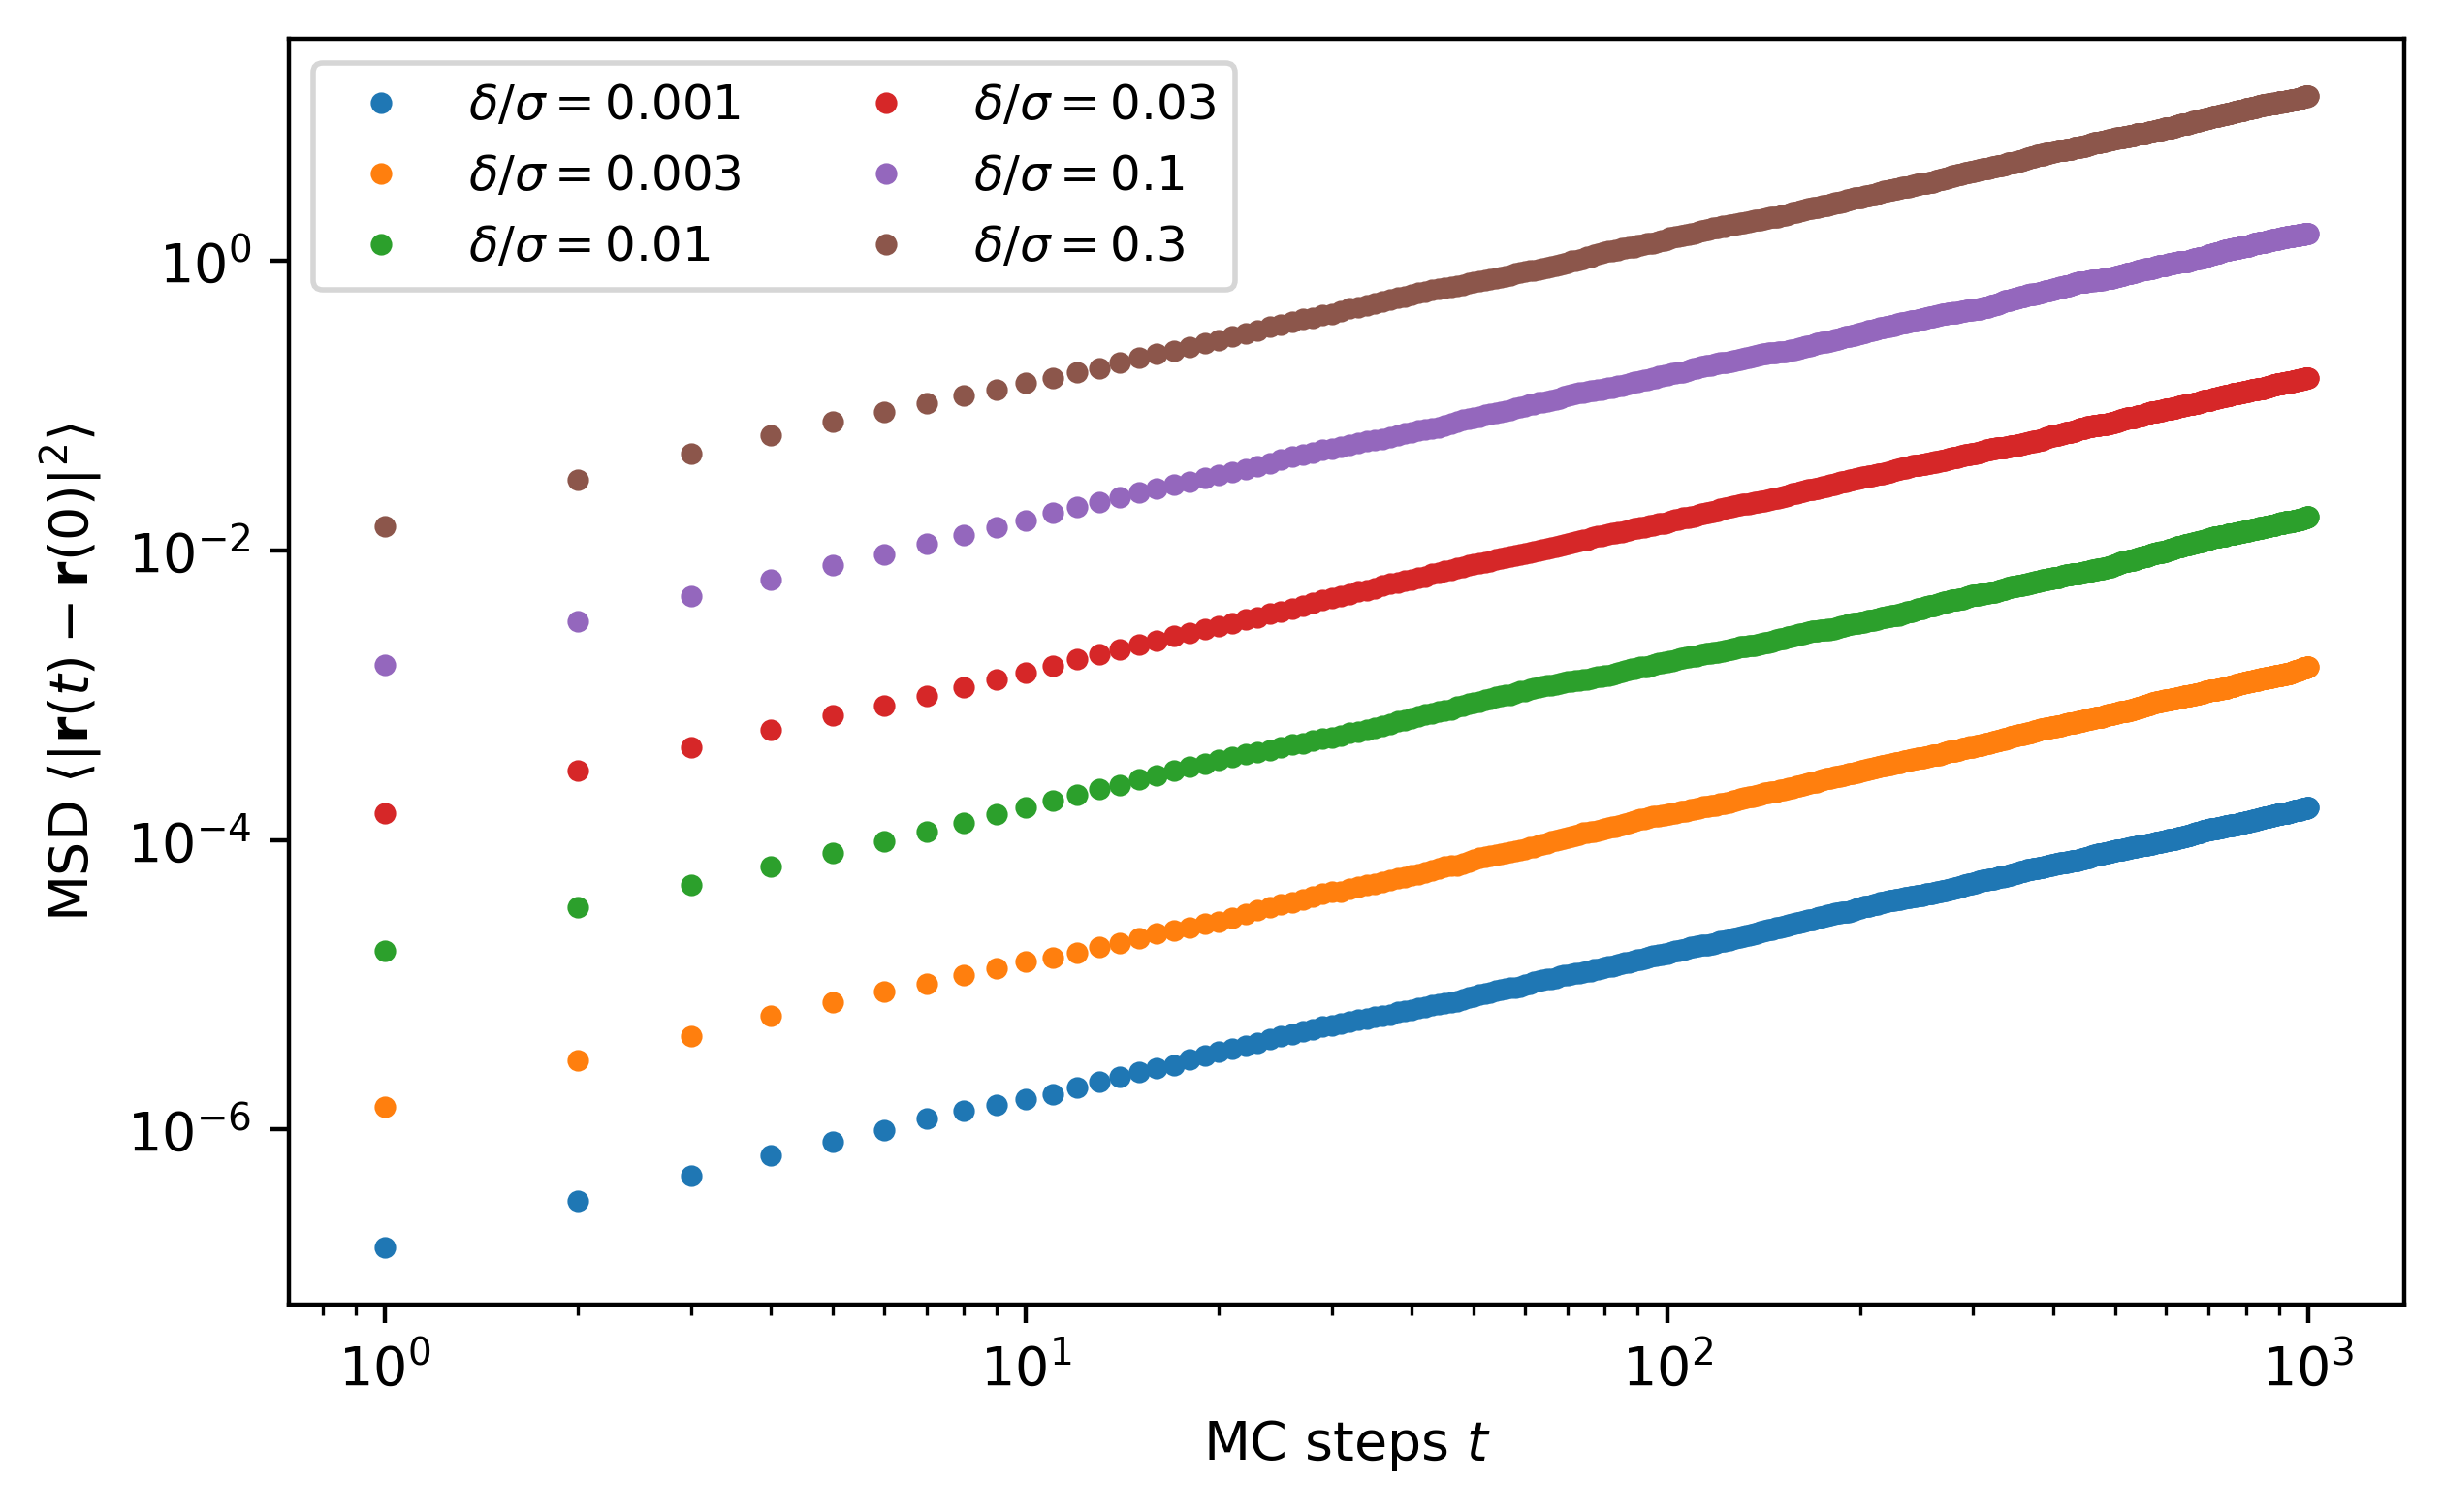

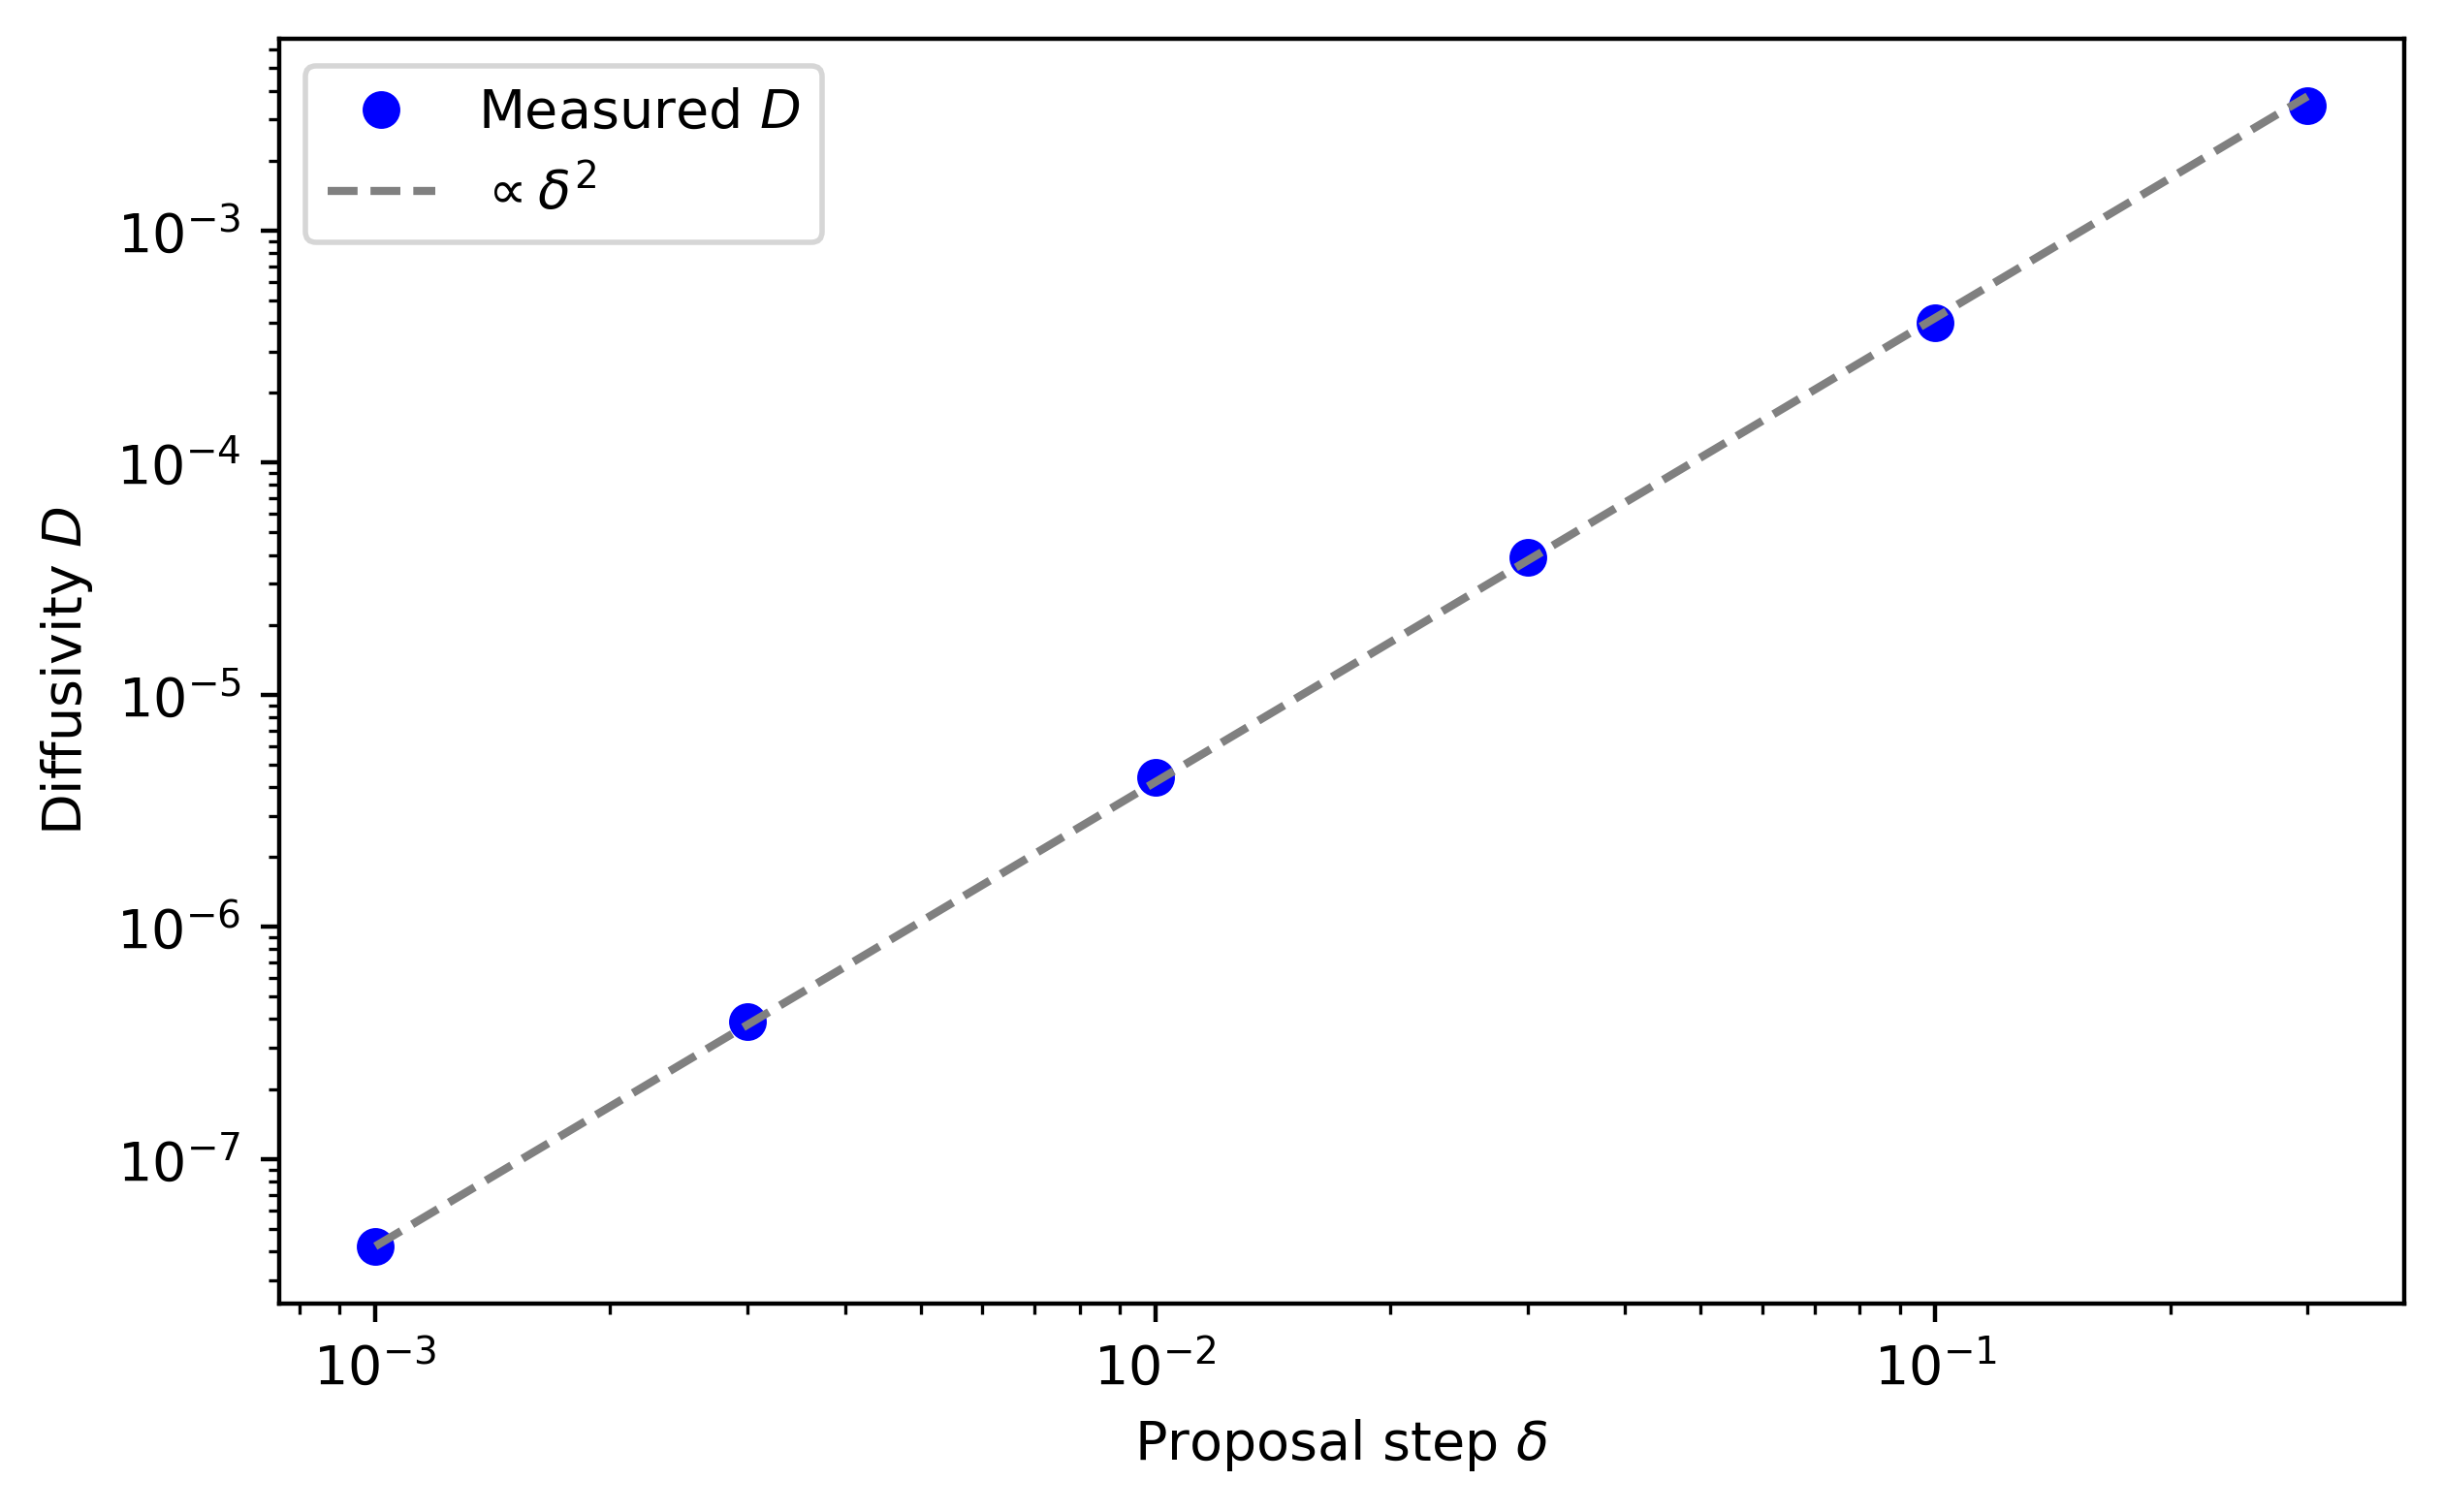


δ/σ   D_est        <acc> (mean acceptance over samples)
0.001  4.2033e-08    1.000
0.003  3.9039e-07    1.000
0.01   4.4240e-06    1.000
0.03   3.9002e-05    0.999
0.1    3.9919e-04    0.997
0.3    3.4517e-03    0.991


In [34]:
# === Q1: Load & Plot =========================================================
import os
import numpy as np
import matplotlib.pyplot as plt

phi_target = 0.05
data_dir = f"q1_phi_{str(phi_target).replace('.','p')}"
summary_path = os.path.join(data_dir, "summary.csv")

# ---- Load summary -----------------------------------------------------------
summary = np.genfromtxt(summary_path, delimiter=",", names=True, dtype=None, encoding=None)

# Ensure arrays and a consistent order by delta
if summary.ndim == 0:
    # Edge case: only one row in summary → turn into 1D arrays
    summary = np.array([summary], dtype=summary.dtype)
order = np.argsort(summary["delta"])
summary = summary[order]

deltas = summary["delta"]
D_arr = summary["D_est"]
acc_means = summary["acc_mean"]

# ---- Figure 1: MSD(t) for all deltas (log–log) -----------------------------
plt.figure(figsize=(6.4,4), dpi=400)

for delta in deltas:
    ts_file = os.path.join(data_dir, f"msd_delta_{str(delta).replace('.','p')}.txt")
    data = np.loadtxt(ts_file, comments="#", delimiter="\t")
    t = data[:,0]
    msd_arr = data[:,1]
    plt.loglog(t, msd_arr, label=fr'$\delta/\sigma={delta:.3g}$', linestyle='None', marker='o', markersize=3)

plt.xlabel('MC steps $t$')
plt.ylabel(r'MSD $\langle|\mathbf{r}(t)-\mathbf{r}(0)|^2\rangle$')
#plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.savefig('MSD_delta', dpi=400)
plt.show()

# ---- Figure 2: D vs δ (log–log) with δ^2 guide -----------------------------
plt.figure(figsize=(6.4,4), dpi=400)
plt.loglog(deltas, D_arr, 'o-', label='Measured $D$', color='blue', linestyle='None', marker='o', markersize=6)

# Reference ~ δ^2 guide anchored to the smallest-δ point
ref = D_arr[0] * (deltas / deltas[0])**2
plt.loglog(deltas, ref, '--', label=r'$\propto \delta^2$', color='grey')

plt.xlabel(r'Proposal step $\delta$')
plt.ylabel(r'Diffusivity $D$')
#plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('D_delta', dpi=400)
plt.show()

# ---- Console table (same as before) ----------------------------------------
print("\nδ/σ   D_est        <acc> (mean acceptance over samples)")
for d, D_est, acc_mean in zip(deltas, D_arr, acc_means):
    print(f"{d:<6.3g} {D_est:>10.4e}   {acc_mean:>6.3f}")


2. How long does it take, in MCs (approximately), to the system to relax to an equilibrium state from an ordered initial configuration where all the particles sit on the sites of an triangular lattice for ϕ = 0.05, 0.2, 0.5, (you can have a look at the MSD and the configuration snapshots to estimate how many MCs you need to reach equilibrium conditions)? Show snapshots of the system (configurations, the position of each particle in the plane) in its steady state at ϕ = 0.05, 0.2, 0.5,. Do you expect a qualitative change (a phase transition?) to occur as the system’s density is varied?

In [5]:
# --- Q2: Relaxation from ordered start; equilibrium time + snapshots + MSD ----------------------
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers: box sizing and triangular lattice -----------------------------------------
def box_for_phi(phi, N, sigma):
    # phi = N π σ^2 / (4 Lx Ly), choose square L
    L = float(np.sqrt(N * np.pi * sigma**2 / (4.0 * phi)))
    return L, L

def triangular_lattice_positions(N, Lx, Ly, sigma, spacing_factor=1.001, rng=None):
    import numpy as np
    if rng is None:
        rng = np.random.default_rng()

    a_min = spacing_factor * sigma  # target spacing (≥ σ)
    if a_min < sigma:
        a_min = sigma

    # propose ny so that ay ≈ Ly/ny with ny even
    ny_guess = max(2, int(np.floor(Ly / (a_min))))
    if ny_guess % 2 == 1:
        ny_guess -= 1
    if ny_guess < 2:
        ny_guess = 2

    # we’ll test a small band of ny around ny_guess to get the closest spacing
    candidates = []
    for ny in range(max(2, ny_guess-4), ny_guess+5):
        if ny % 2 == 1:
            continue
        ay = Ly / ny
        a  = ay   # implied a from ny
        nx = max(1, int(np.floor(Lx / a)))
        a_eff  = Lx / nx       # exact commensurate a in x
        ay_eff = a_eff
        if a_eff < sigma:   # reject overlaps
            continue
        # distance to target spacing
        cost = abs(a_eff - a_min)
        candidates.append((cost, nx, ny, a_eff, ay_eff))

    if not candidates:
        raise ValueError("No commensurate lattice without overlaps fits this box with the requested spacing.")

    _, nx, ny, a, ay = min(candidates, key=lambda t: t[0])

    # build lattice
    pts = []
    for j in range(ny):
        y  = j * ay
        x0 = 0.0 if (j % 2 == 0) else 0.5 * a
        for i in range(nx):
            x = x0 + i * a
            if x >= Lx:  # numerical safety
                x -= Lx
            pts.append([x, y])
    pts = np.array(pts, float)

    M = len(pts)
    if N > M:
        raise ValueError(f"N={N} exceeds lattice sites M={M} (nx={nx}, ny={ny}).")
    idx = rng.choice(M, size=N, replace=False)
    return pts[idx]

# ---------- run from ordered init with an equilibration criterion --------------------------------
def relax_from_ordered(phi, delta, n_steps_cap=300000, sample_every=10,
                       slope_window=40, rel_tol=0.08, min_MCs=500, msd_threshold=6.0):
    global Lx, Ly  # use your globals in geometry/minimum-image
    Lx, Ly = box_for_phi(phi, N, sigma)
    pos0 = triangular_lattice_positions(N, Lx, Ly, sigma)

    # Initialize wrapped/unwrapped and a fresh NeighborGrid via your fast init:
    # We'll mirror run_sim_fast but start from pos0 instead of random placement.
    # Build grid and register all particles:
    grid = NeighborGrid(Lx, Ly, sigma)
    grid.init_empty(N)
    pos = wrap_pbc(pos0.copy())
    for i in range(N):
        grid.add_particle(i, pos[i])
    pos_u = pos.copy()
    pos_u0 = pos_u.copy()

    times, msds, accs = [], [], []
    t_eq = None

    for t in range(1, n_steps_cap + 1):
        i = N-1
        acc = mc_step_fast(pos, pos_u, delta, grid)
        
        if t % sample_every == 0:
            times.append(t)
            disp = pos_u - pos_u0
            msds.append(float((disp**2).sum(axis=1).mean()))
            accs.append(acc)

            if (len(times) >= 2*slope_window) and (t >= min_MCs):
                x = np.array(times, float); y = np.array(msds, float)
                x1, y1 = x[-2*slope_window:-slope_window], y[-2*slope_window:-slope_window]
                x2, y2 = x[-slope_window:],            y[-slope_window:]
                s1, _ = np.polyfit(x1, y1, 1)
                s2, _ = np.polyfit(x2, y2, 1)
                # Require that the system has diffused a few σ to forget the lattice
                if (y2.mean() > msd_threshold * sigma**2) and (abs(s2 - s1)/max(abs(s1),1e-12) < rel_tol):
                    t_eq = x2[-1]
                    break

    if t_eq is None:
        t_eq = times[-1]
    # Estimate D from long-time slope (last half of collected samples)
    n = len(times)
    fit_slice = slice(n//2, n)
    slope, _ = np.polyfit(np.array(times, float)[fit_slice], np.array(msds, float)[fit_slice], 1)
    D_est = slope / 4.0

    return {
        "phi": phi,
        "t": np.array(times, float),
        "msd": np.array(msds, float),
        "acc": np.array(accs, float),
        "pos_final": pos.copy(),
        "t_eq": float(t_eq),
        "D_est": float(D_est),
        "Lx": float(Lx), "Ly": float(Ly)
    }

In [49]:
# ---------- main experiment ----------------------------------------------------------------------
phi_list = [0.05, 0.20, 0.50]
#phi_list = [0.05]
N = 1000
delta = sigma / 10.0   # typical efficient choice
results = []

for phi in phi_list:
    out = relax_from_ordered(phi, delta,
                             n_steps_cap=10000, sample_every=1,
                             slope_window=10, rel_tol=0.1, min_MCs=500, msd_threshold=10.0)
    results.append(out)
    print(f"[φ={phi:.2f}] t_eq ≈ {out['t_eq']:.0f} MCs,  D ≈ {out['D_est']:.3e}, "
          f"<acc> ≈ {out['acc'].mean():.3f},  L={out['Lx']:.3f}")

[φ=0.05] t_eq ≈ 6455 MCs,  D ≈ 3.552e-04, <acc> ≈ 0.995,  L=125.331
[φ=0.20] t_eq ≈ 9284 MCs,  D ≈ 2.550e-04, <acc> ≈ 0.972,  L=62.666
[φ=0.50] t_eq ≈ 10000 MCs,  D ≈ 1.044e-04, <acc> ≈ 0.859,  L=39.633


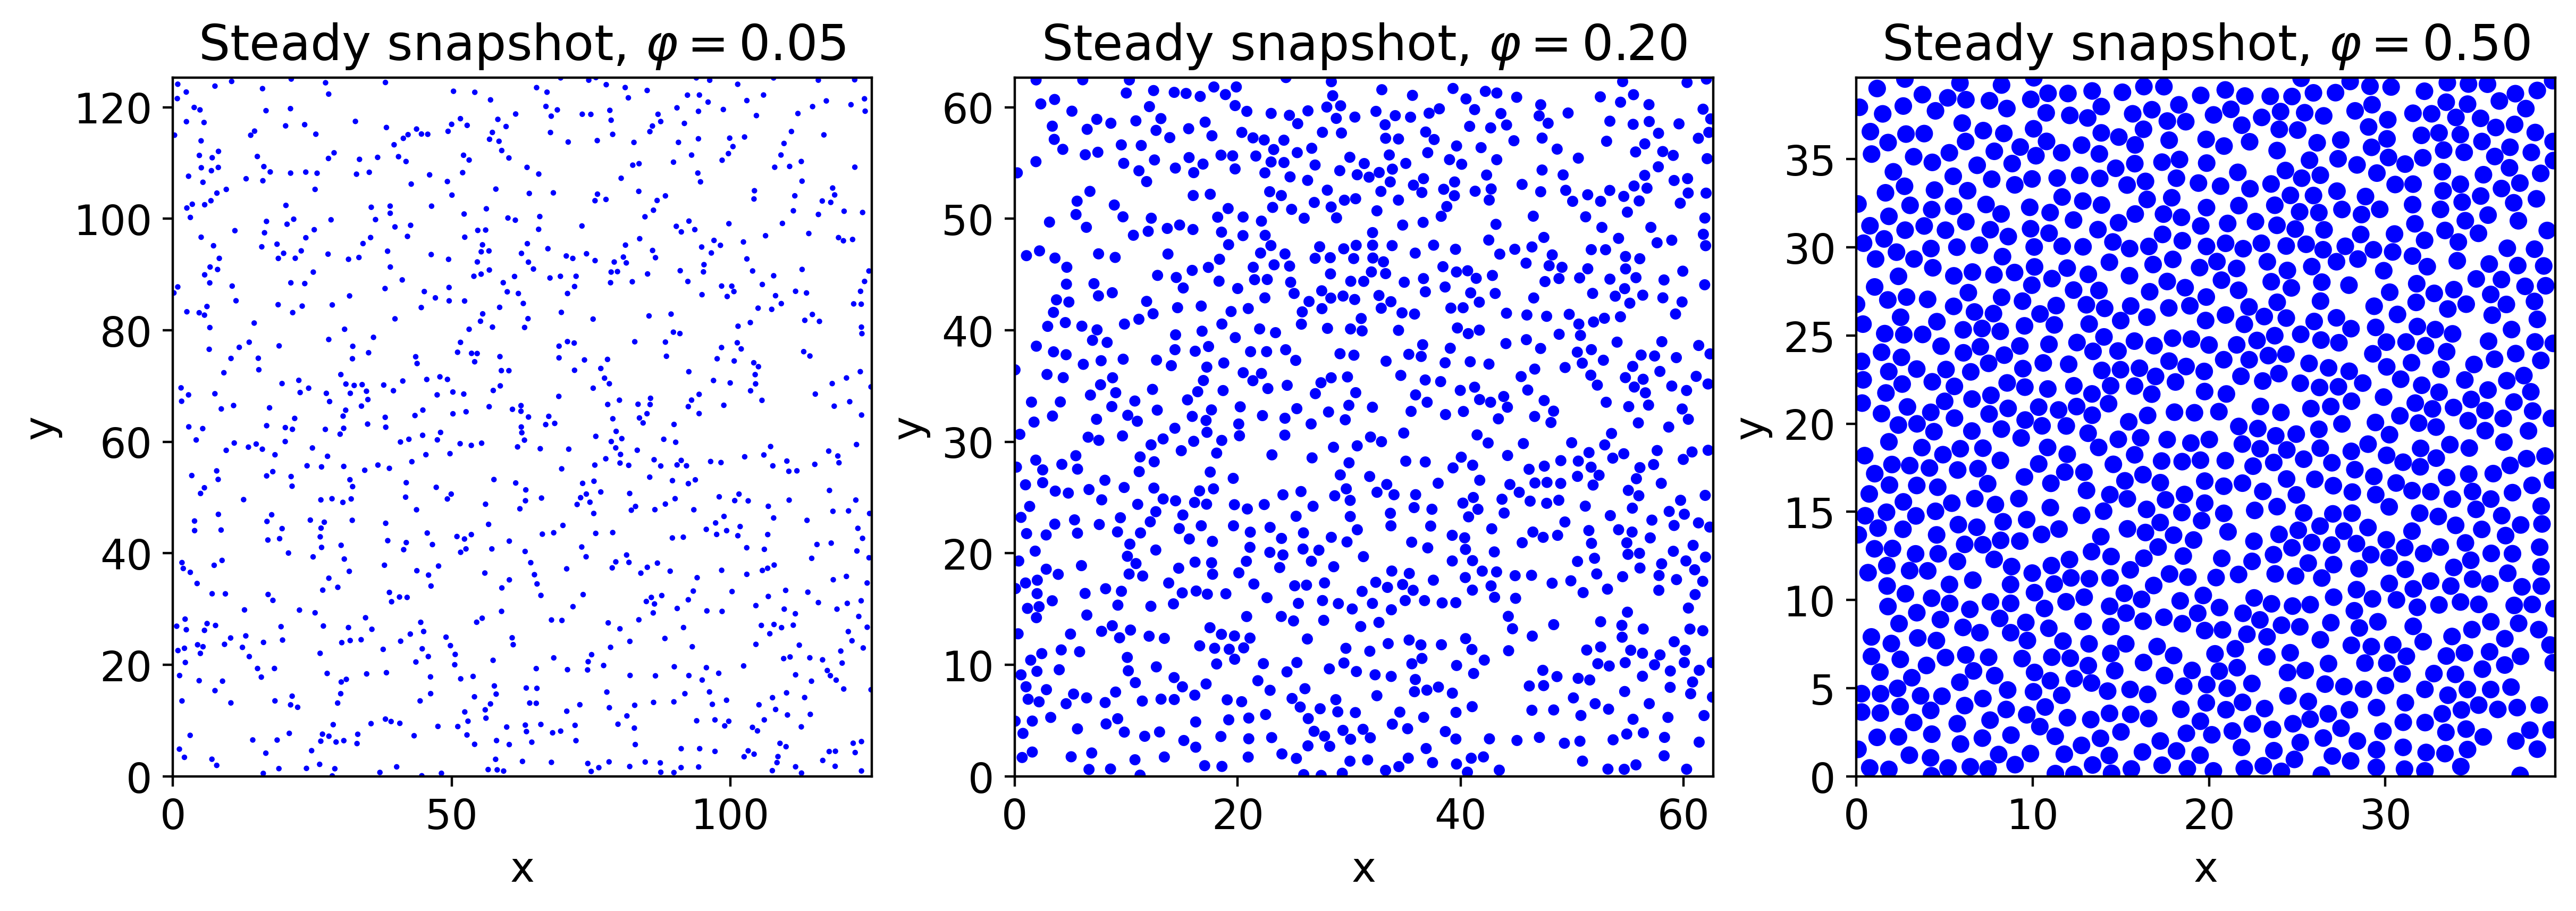

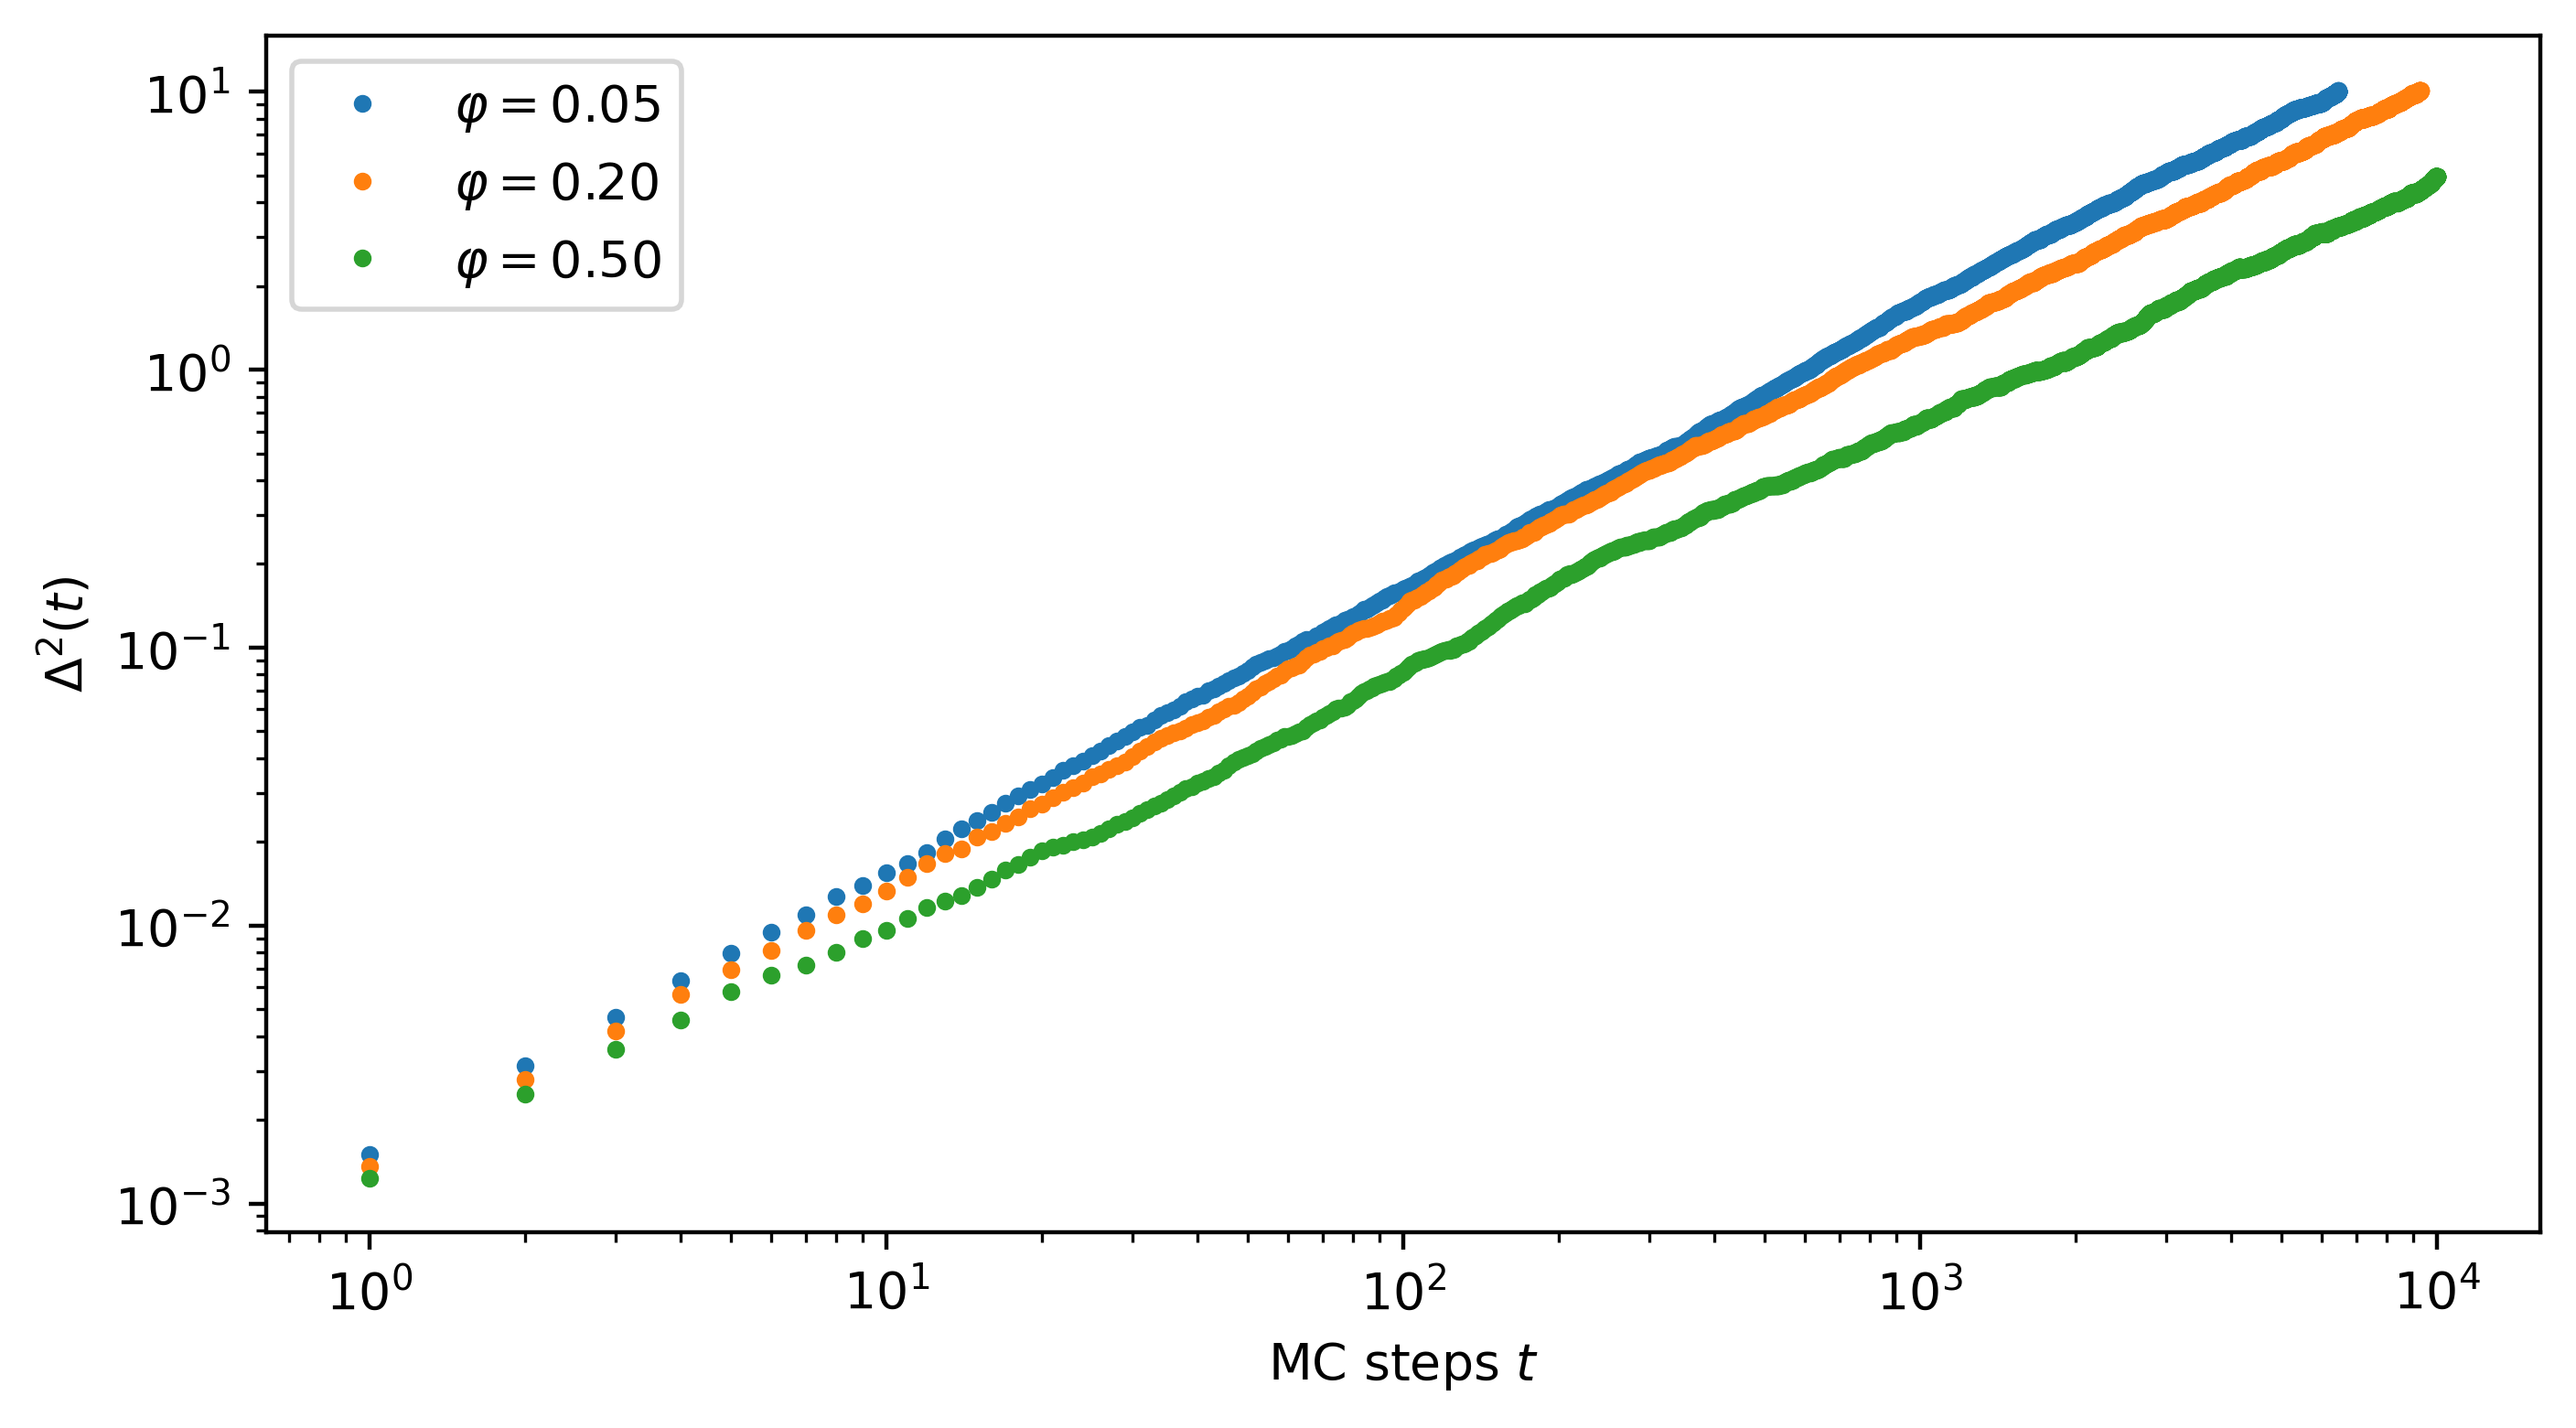

In [59]:
# ---------- snapshots at steady state ------------------------------------------------------------
import matplotlib.patches as mpatches
from matplotlib import rcParams

with plt.rc_context({'font.size': 14}):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4.2), dpi=400, constrained_layout=True)
    # for ax, out in zip(axes, results):
    #     pos_final = out["pos_final"]
    #     ax.scatter(pos_final[:,0], pos_final[:,1], s=sigma, color='blue')
    #     ax.set_title(fr"Steady snapshot, $\varphi={out['phi']:.2f}$")
    #     ax.set_xlabel("x"); ax.set_ylabel("y")
    #     ax.set_aspect('equal', adjustable='box')
    #     ax.set_xlim(0, out["Lx"]); ax.set_ylim(0, out["Ly"])

    for ax, out in zip(axes, results):
        pos_final = out["pos_final"]
        Lx, Ly = out["Lx"], out["Ly"]

        # draw each disk with radius = sigma
        for (x, y) in pos_final:
            circ = mpatches.Circle((x, y), radius=sigma/2, fc='blue', ec='none')
            ax.add_patch(circ)

        ax.set_title(fr"Steady snapshot, $\varphi={out['phi']:.2f}$")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(0, Lx)
        ax.set_ylim(0, Ly)
    #plt.savefig('SteadySnapshots')
    plt.show()

# ---------- MSD traces documenting relaxation ----------------------------------------------------
plt.figure(figsize=(7, 4), dpi=400)
for out in results:
    plt.plot(out["t"], out["msd"], label=fr'$\varphi={out["phi"]:.2f}$',  linestyle='None', marker='o', markersize=2.5)
plt.xlabel("MC steps $t$")
plt.ylabel(r'$\Delta^2(t)$')
#plt.title("Relaxation from triangular lattice: MSD vs. $t$ (log–log)")
#plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')
#plt.savefig('Delta_t_diffphi')
plt.show()

3. Consider now the system in a closed box, of size Lx×Ly in which the particle-wall interactionsMScPhysicsofComplexSystemsandBiophysics,2024-2025 arehardcore, of thesamenatureas theparticle-particleones. Howdoyouhavetoadapt the Metropolisalgorithmtotakeintoaccounttheconfininggeometry?

In [6]:
def inside_walls(r):
    return (sigma <= r[0] <= Lx - sigma) and (sigma <= r[1] <= Ly - sigma)

def attempt_move_closed(i, pos, pos_u, delta):
    r_old = pos[i].copy()
    du = propose_displacement(delta)
    r_trial_u = pos_u[i] + du
    r_trial   = r_old + du

    # 1) Hard-wall geometry
    if not inside_walls(r_trial):
        return False

    # 2) Overlaps (Euclidean distance; NO minimum-image)
    contact2 = (2.0 * sigma)**2
    for j in range(N):
        if j == i: 
            continue
        if ((r_trial - pos[j])**2).sum() < contact2:
            return False

    # 3) External energies (if any; e.g., gravity)
    dE = m*g*(r_trial_u[1] - pos_u[i][1])
    if dE > 0.0 and rng.random() > np.exp(-beta(T)*dE):
        return False

    # Accept
    pos[i]   = r_trial
    pos_u[i] = r_trial_u
    return True

class NeighborGrid:
    def __init__(self, Lx, Ly, sigma, periodic=True):
        self.Lx, self.Ly = float(Lx), float(Ly)
        self.periodic = periodic
        self.contact = 2.0 * sigma
        self.cs = self.contact * 1.01
        self.ncx = max(3, int(np.floor(self.Lx / self.cs)))
        self.ncy = max(3, int(np.floor(self.Ly / self.cs)))
        self.csx = self.Lx / self.ncx
        self.csy = self.Ly / self.ncy
        self.cells = None
        self.where = None  # (ix, iy, k)

    def _cell_of(self, r):
        ix = int(np.floor(r[0] / self.csx))
        iy = int(np.floor(r[1] / self.csy))
        if self.periodic:
            ix %= self.ncx
            iy %= self.ncy
        else:
            ix = min(max(ix, 0), self.ncx-1)
            iy = min(max(iy, 0), self.ncy-1)
        return ix, iy

    def neighbors_indices(self, r):
        ix, iy = self._cell_of(r)
        for dx in (-1, 0, 1):
            cx = ix + dx
            if self.periodic:
                cx %= self.ncx
            elif not (0 <= cx < self.ncx):
                continue
            for dy in (-1, 0, 1):
                cy = iy + dy
                if self.periodic:
                    cy %= self.ncy
                elif not (0 <= cy < self.ncy):
                    continue
                yield from self.cells[cx][cy]

def mc_step_fast_closed(pos, pos_u, delta, grid, g):
    acc = 0
    contact2 = (2.0 * sigma)**2
    for _ in range(N):
        i = rng.integers(0, N)
        r_old = pos[i].copy()
        du = delta * (rng.random(2) - 0.5)
        r_trial_u = pos_u[i] + du
        r_trial = r_old + du

        # hard walls
        if not inside_walls(r_trial):
            continue

        # neighbor overlaps (no PBC distances)
        overlap = False
        for j in grid.neighbors_indices(r_trial):
            if j == i: 
                continue
            if ((r_trial - pos[j])**2).sum() < contact2:
                overlap = True
                break
        if overlap:
            continue

        # external energy (e.g., gravity)
        dE = m*g*(r_trial_u[1] - pos_u[i][1])
        if dE > 0.0 and rng.random() > np.exp(-beta(T)*dE):
            continue

        # accept
        pos[i] = r_trial
        pos_u[i] = r_trial_u
        grid.move_particle(i, r_old, r_trial)
        acc += 1
    return acc / N

def init_positions_random_fast_closed():
    positions = np.full((N, 2), np.nan, dtype=float)
    grid = NeighborGrid(Lx, Ly, sigma, periodic=False)
    grid.init_empty(N)
    contact2 = (2.0 * sigma)**2

    def overlaps_any(r):
        for j in grid.neighbors_indices(r):
            if not np.isfinite(positions[j,0]): 
                continue
            if ((r - positions[j])**2).sum() < contact2:
                return True
        return False

    placed = 0
    while placed < N:
        # sample uniformly in the **accessible** box
        r_trial = np.array([rng.uniform(sigma, Lx - sigma),
                            rng.uniform(sigma, Ly - sigma)], float)
        if placed == 0 or not overlaps_any(r_trial):
            positions[placed] = r_trial
            grid.add_particle(placed, r_trial)
            placed += 1

    return positions, grid

def run_sim_fast_closed(n_steps=2000, delta=sigma/10, sample_every=10, g=9.8):
    pos, grid = init_positions_random_fast_closed()
    pos_u = pos.copy()
    pos_u0 = pos_u.copy()
    times, msds, accs = [], [], []
    for t in range(1, n_steps+1):
        acc = mc_step_fast_closed(pos, pos_u, delta, grid, g)
        if t % sample_every == 0:
            times.append(t)
            disp = pos_u - pos_u0
            msds.append(float((disp**2).sum(axis=1).mean()))
            accs.append(acc)
    return {"t": np.array(times), "msd": np.array(msds), "acc": np.array(accs)}

5. JeanPerrin’svirtual experiment 1: Using an elongated closed box Lx×Ly, with Ly=10Lx  in a constant gravity field along the y-axis, simulate a system of hard disks with N=1000, m=1 at T=1. Choose Lx wisely. Plot the equilibrium configurations of the system for g=0,0.01,0.1,1,10.Comment the snapshots.

In [7]:
# --- Jean Perrin virtual experiment: closed box, Ly=10 Lx, phi=0.05, g in {0, 0.01, 0.1, 1, 10} ---
import numpy as np
import matplotlib.pyplot as plt

# -------- Bug version fix--------
# --- Compatibility patch for older NeighborGrid (adds init_empty/add_particle) ---
if not hasattr(NeighborGrid, "init_empty"):
    def _ng_init_empty(self, N):
        # allocate empty cells and where table; prefer (ix,iy,k) if possible
        self.cells = [[[] for _ in range(self.ncy)] for _ in range(self.ncx)]
        self.where = np.full((N, 3), -1, dtype=int)  # (ix, iy, index_in_cell)

    def _ng_add_particle(self, i, r):
        ix = int(np.floor(r[0] / self.csx))
        iy = int(np.floor(r[1] / self.csy))
        # clamp to box (closed); if your class supports periodic, you can mod instead
        ix = min(max(ix, 0), self.ncx - 1)
        iy = min(max(iy, 0), self.ncy - 1)
        lst = self.cells[ix][iy]
        lst.append(i)
        self.where[i] = (ix, iy, len(lst) - 1)

    def _ng_move_particle(self, i, r_old, r_new):
        ix_old, iy_old, k_old = self.where[i]
        # add if not registered
        if ix_old < 0:
            _ng_add_particle(self, i, r_new)
            return
        # compute new cell (clamped)
        ix_new = int(np.floor(r_new[0] / self.csx)); iy_new = int(np.floor(r_new[1] / self.csy))
        ix_new = min(max(ix_new, 0), self.ncx - 1)
        iy_new = min(max(iy_new, 0), self.ncy - 1)
        if (ix_new == ix_old) and (iy_new == iy_old):
            return
        # O(1) remove via swap-with-last
        lst_old = self.cells[ix_old][iy_old]
        last_i = lst_old[-1]
        lst_old[k_old] = last_i
        lst_old.pop()
        if last_i != i:  # update swapped
            self.where[last_i] = (ix_old, iy_old, k_old)
        # add to new
        lst_new = self.cells[ix_new][iy_new]
        lst_new.append(i)
        self.where[i] = (ix_new, iy_new, len(lst_new) - 1)

    NeighborGrid.init_empty = _ng_init_empty
    NeighborGrid.add_particle = _ng_add_particle
    NeighborGrid.move_particle = _ng_move_particle


# ----- Fast closed-box initializer (uses your NeighborGrid with periodic=False) -----
def init_positions_random_fast_closed():
    positions = np.full((N, 2), np.nan, dtype=float)
    grid = NeighborGrid(Lx, Ly, sigma, periodic=False)
    grid.init_empty(N)
    contact2 = (2.0 * sigma)**2

    def overlaps_any(r):
        for j in grid.neighbors_indices(r):
            if not np.isfinite(positions[j,0]): 
                continue
            if ((r - positions[j])**2).sum() < contact2:
                return True
        return False

    placed = 0
    attempts_cap = 20000
    while placed < N:
        for _ in range(attempts_cap):
            r_trial = np.array([rng.uniform(sigma, Lx - sigma),
                                rng.uniform(sigma, Ly - sigma)], float)
            if placed == 0 or not overlaps_any(r_trial):
                positions[placed] = r_trial
                grid.add_particle(placed, r_trial)
                placed += 1
                break
        else:
            raise RuntimeError("Could not place particle—reduce phi or enlarge box.")
    return positions, grid

# ----- One MC sweep with hard walls + gravity (closed box) -----
def mc_step_fast_closed_with_gravity(pos, pos_u, delta, grid, g):
    acc = 0
    contact2 = (2.00*sigma)**2
    for _ in range(N):
        i = rng.integers(0, N)
        r_old = pos[i].copy()
        du = delta * (rng.random(2) - 0.5)

        r_trial_u = pos_u[i] + du
        r_trial   = r_old + du

        # hard-wall constraint
        if not inside_walls(r_trial):
            continue

        # neighbor overlaps (no minimum-image in closed box)
        overlap = False
        for j in grid.neighbors_indices(r_trial):
            if j == i:
                continue
            if ((r_trial - pos[j])**2).sum() < contact2:
                overlap = True
                break
        if overlap:
            continue

        # gravity energy: ΔE = m g (y' - y)
        dE = m * g * (r_trial_u[1] - pos_u[i][1])
        if dE > 0.0 and rng.random() > np.exp(-beta(T)*dE):
            continue

        # accept
        pos[i]   = r_trial
        pos_u[i] = r_trial_u
        grid.move_particle(i, r_old, r_trial)
        acc += 1
    return acc / N

# ----- Run until equilibrium based on stabilization of <y> (mean height) -----
def run_to_equilibrium_sedimentation(g, delta=None, n_steps_cap=10**6, sample_every=20,
                                     window=40, rel_tol=5e-3, abs_tol=None, min_MCs=100):
    """
    Stop when the mean y over the last two windows changes little:
        |<y>_2 - <y>_1| / Ly < rel_tol  and  absolute change < abs_tol (if given),
    after a minimum number of sweeps. This targets stationarity of the vertical density.
    """
    if delta is None:
        delta = sigma/10

    pos, grid = init_positions_random_fast_closed()
    pos_u = pos.copy()

    times, means_y, accs = [], [], []
    t_eq = None

    if abs_tol is None:
        abs_tol = 1e-3 * Ly

    for t in range(1, n_steps_cap + 1):
        acc = mc_step_fast_closed_with_gravity(pos, pos_u, delta, grid, g)
        if t % sample_every == 0:
            times.append(t)
            means_y.append(float(pos[:,1].mean()))
            accs.append(acc)

            if (len(times) >= 2*window) and (t >= min_MCs):
                y1 = np.mean(means_y[-2*window:-window])
                y2 = np.mean(means_y[-window:])
                if (abs(y2 - y1) / Ly < rel_tol) and (abs(y2 - y1) < abs_tol):
                    t_eq = times[-1]
                    break

    if t_eq is None:
        t_eq = times[-1]

    return {
        "g": g,
        "t_eq": t_eq,
        "pos_final": pos.copy(),
        "y_mean": np.array(means_y, float),
        "t": np.array(times, float),
        "acc": np.array(accs, float),
        "Lx": Lx, "Ly": Ly
    }

In [20]:
# ----- Problem setup -----
# Choose target phi and box BEFORE globals().update
phi_target = 0.4  
N = 200

# Box from phi in an elongated geometry Ly = 10 Lx:
Lx = float(np.sqrt(N * np.pi * sigma**2 / (10 * phi_target)))
Ly = 10.0 * Lx

globals().update({"Lx": Lx, "Ly": Ly})  

print(f"[Perrin setup] N={N}, sigma={sigma}, T={T}, phi={phi_target}, Lx={Lx:.3f}, Ly={Ly:.3f} (Ly=10 Lx)")

g_list = [0.0, 0.7, 0.9, 1.0, 10.0]
m = 1.0
T = 1.0

import numpy as np

# ----- Main loop over g values -----
delta = sigma / 10
results = []

for g in g_list:
    out = run_to_equilibrium_sedimentation(
        g, delta=delta,
        n_steps_cap=10**6, sample_every=100,
        window=20, rel_tol=1e-4, abs_tol=None, min_MCs=1000
    )
    results.append(out)

    # --- Print summary on screen ---
    print(f"[g={g:>4}]  t_eq ≈ {out['t_eq']:.0f} MCs, "
          f"<y>_eq ≈ {np.mean(out['y_mean'][-50:]):.3f}, "
          f"<acc> ≈ {out['acc'].mean():.3f}")

    # --- Save results to .txt files for later use ---
    g_str = f"{g:.3g}".replace(".", "p")  # safe for filenames (e.g. g=0.01 -> '0p01')
    base = f"sedimentation_g{g_str}"

    # (1) final positions: N lines, x  y
    np.savetxt(f"{base}_pos_final.txt", out["pos_final"],
               header=f"Final positions (x y) for g={g}, N={N}, phi={phi_target}, Lx={out['Lx']}, Ly={out['Ly']}")

    # (2) time series of mean height and acceptance
    np.savetxt(f"{base}_ymean_acc.txt",
               np.column_stack([out["t"], out["y_mean"], out["acc"]]),
               header="t(MCs)   <y>   acceptance   (equilibrium tracking)")

    # (3) metadata file with basic parameters
    with open(f"{base}_info.txt", "w") as f:
        f.write("# Sedimentation run summary\n")
        f.write(f"g = {g}\n")
        f.write(f"t_eq = {out['t_eq']}\n")
        f.write(f"Lx = {out['Lx']}\nLy = {out['Ly']}\n")
        f.write(f"N = {N}\nsigma = {sigma}\nphi = {phi_target}\nT = {T}\nm = {m}\n")
        f.write(f"delta = {delta}\n")
        f.write(f"Mean <y> (last 50 samples) = {np.mean(out['y_mean'][-50:]):.6f}\n")
        f.write(f"Mean acceptance = {out['acc'].mean():.4f}\n")

[Perrin setup] N=200, sigma=1.0, T=1.0, phi=0.4, Lx=12.533, Ly=125.331 (Ly=10 Lx)
[g= 0.0]  t_eq ≈ 7600 MCs, <y>_eq ≈ 62.639, <acc> ≈ 0.946
[g= 0.7]  t_eq ≈ 198500 MCs, <y>_eq ≈ 35.155, <acc> ≈ 0.841
[g= 0.9]  t_eq ≈ 149400 MCs, <y>_eq ≈ 33.405, <acc> ≈ 0.801
[g= 1.0]  t_eq ≈ 196500 MCs, <y>_eq ≈ 31.135, <acc> ≈ 0.732
[g=10.0]  t_eq ≈ 28400 MCs, <y>_eq ≈ 31.515, <acc> ≈ 0.380


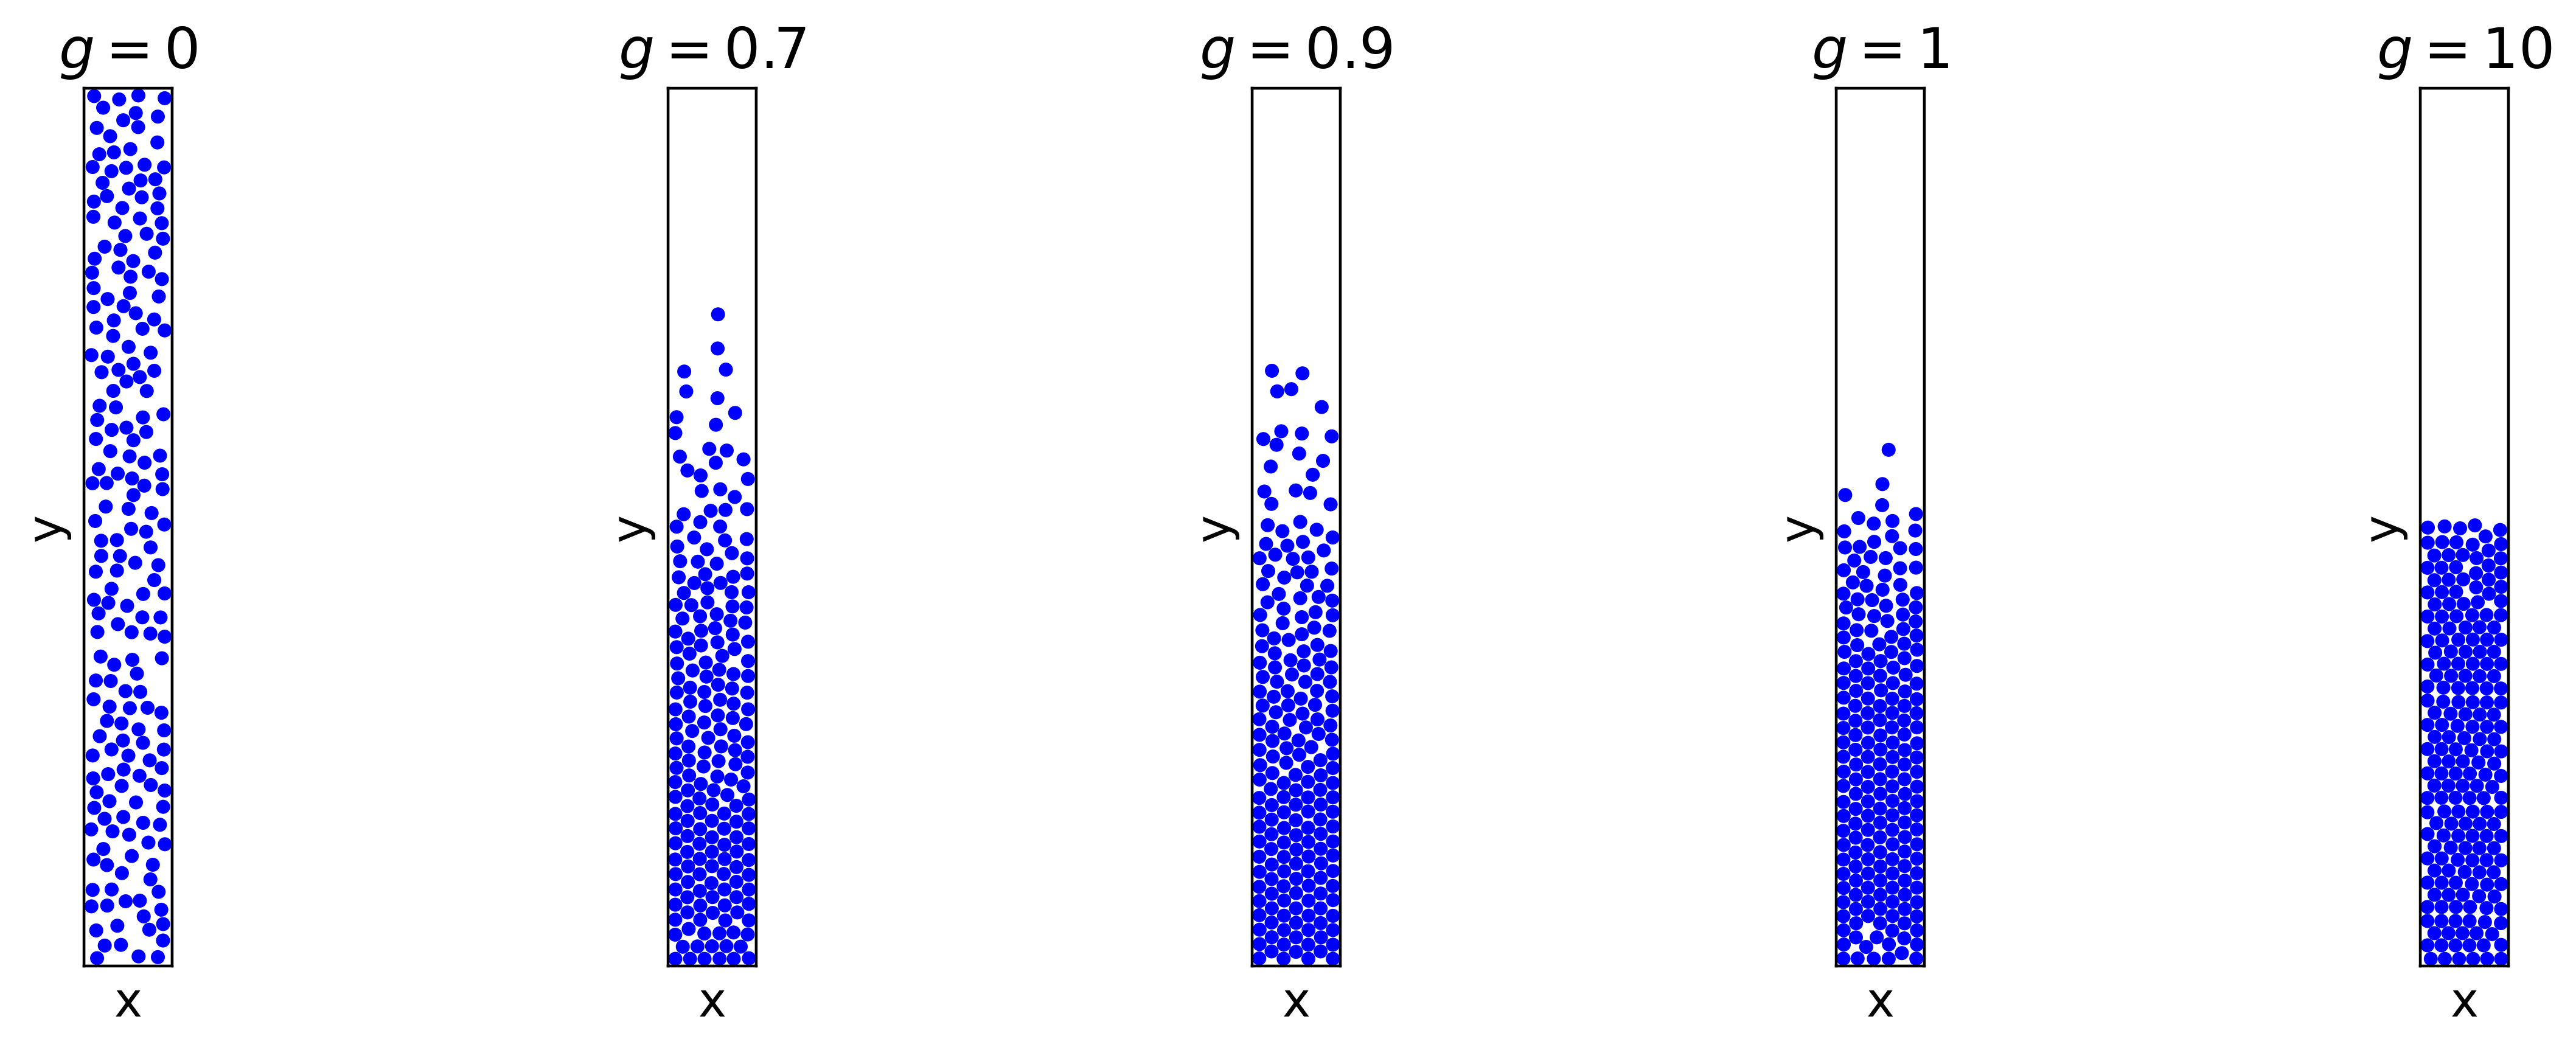

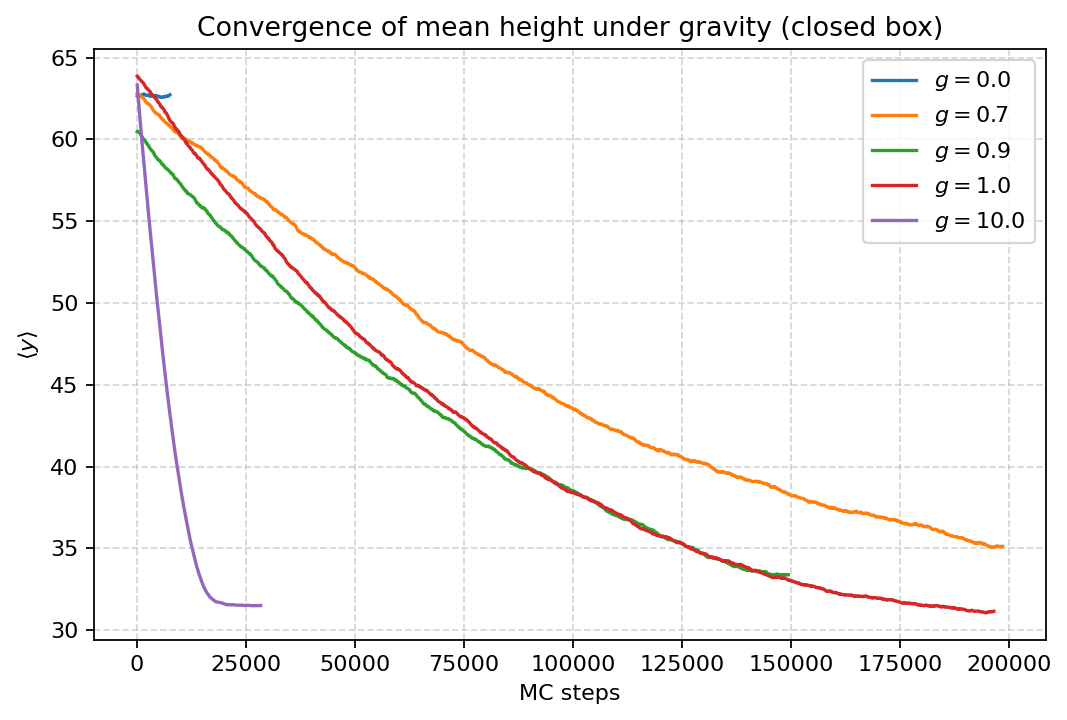

In [21]:
# ---- Snapshots (equilibrium configurations) with true disks (no artefacts) ----
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib.collections import PatchCollection

with plt.rc_context({'font.size': 14}):
    ncols = len(g_list)
    fig, axes = plt.subplots(1, ncols, figsize=(12, 4.2), dpi=400, constrained_layout=True)

    for ax, out in zip(axes, results):
        pos = out["pos_final"]
        Lx_, Ly_ = out["Lx"], out["Ly"]
        gval = out["g"]

        # Box
        ax.add_patch(Rectangle((0, 0), Lx_, Ly_, fill=False, linewidth=0.8, edgecolor="0.25"))

        # Particles with radius = sigma (actual units of the system)
        patches = [Circle((x, y), radius=sigma) for (x, y) in pos]
        coll = PatchCollection(
            patches,
            facecolor='blue',     # todas las partículas azules
            edgecolor='none',     # sin contorno
            linewidths=0.0
        )
        ax.add_collection(coll)

        ax.set_title(fr"$g={gval:g}$")
        ax.set_xlabel("x"); ax.set_ylabel("y")
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(0, Lx_); ax.set_ylim(0, Ly_)
        ax.set_xticks([]); ax.set_yticks([])

    # fig.suptitle(rf"Sedimentation snapshots for $N={N}$")
    # fig.savefig('GravitySnapshots_blue.png', dpi=400)
    plt.show()


# ---- (Optional) Convergence of mean height to equilibrium ----
plt.figure(figsize=(6.8,4.6), dpi=160)
for out in results:
    plt.plot(out["t"], out["y_mean"], label=fr"$g={out['g']}$")
plt.xlabel("MC steps")
plt.ylabel(r"$\langle y \rangle$")
plt.title(r"Convergence of mean height under gravity (closed box)")
plt.grid(True, ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

**6. Density profiles**

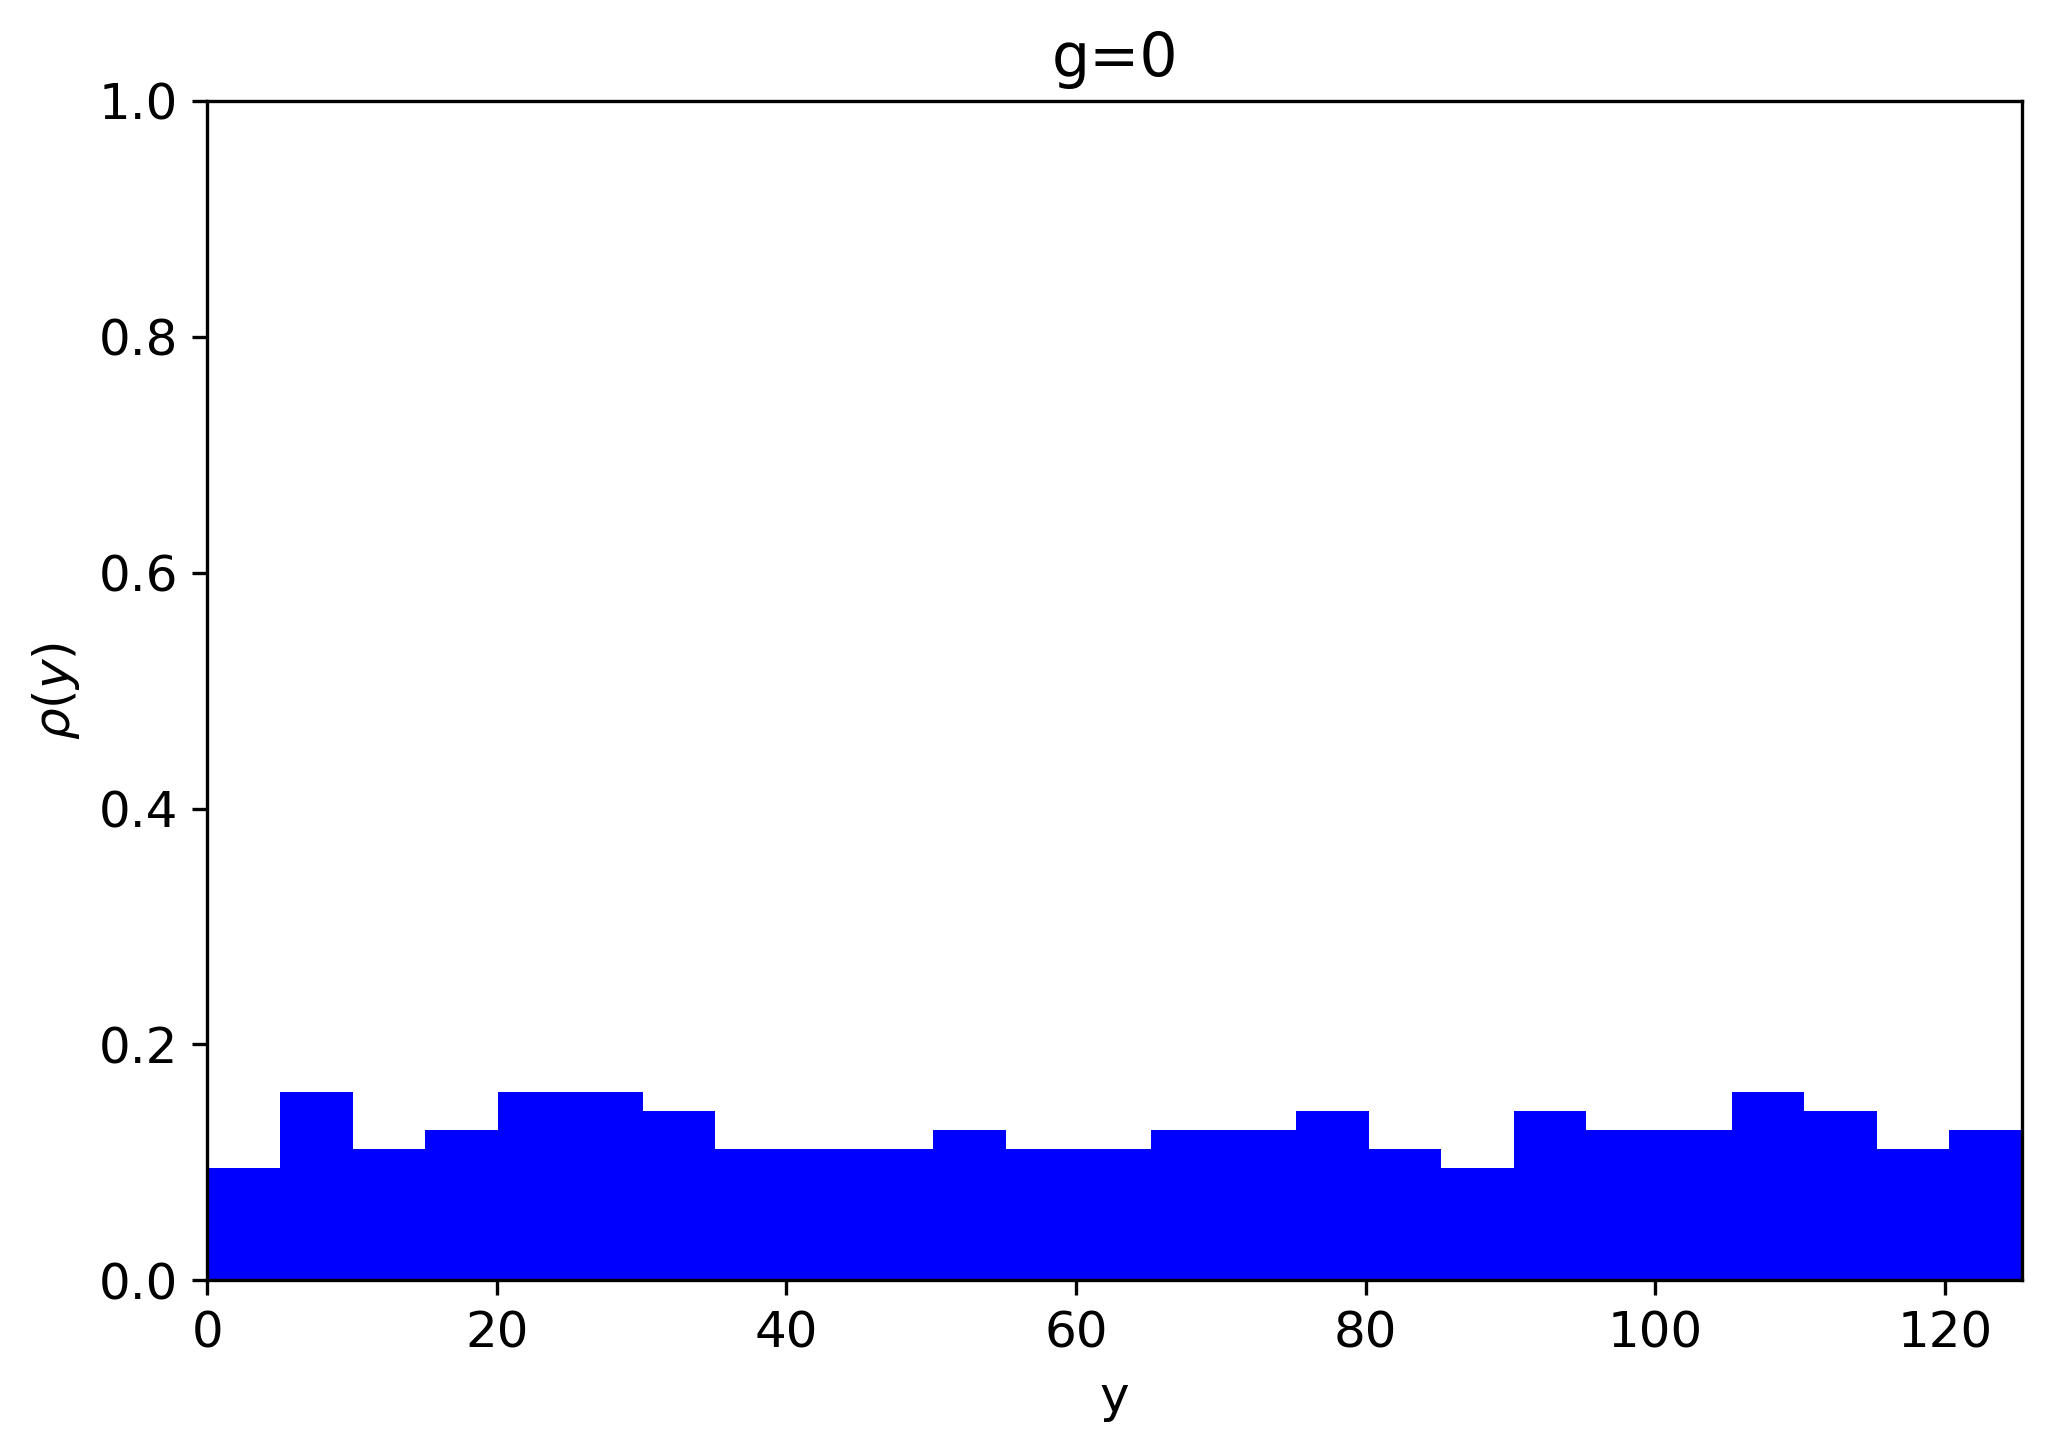

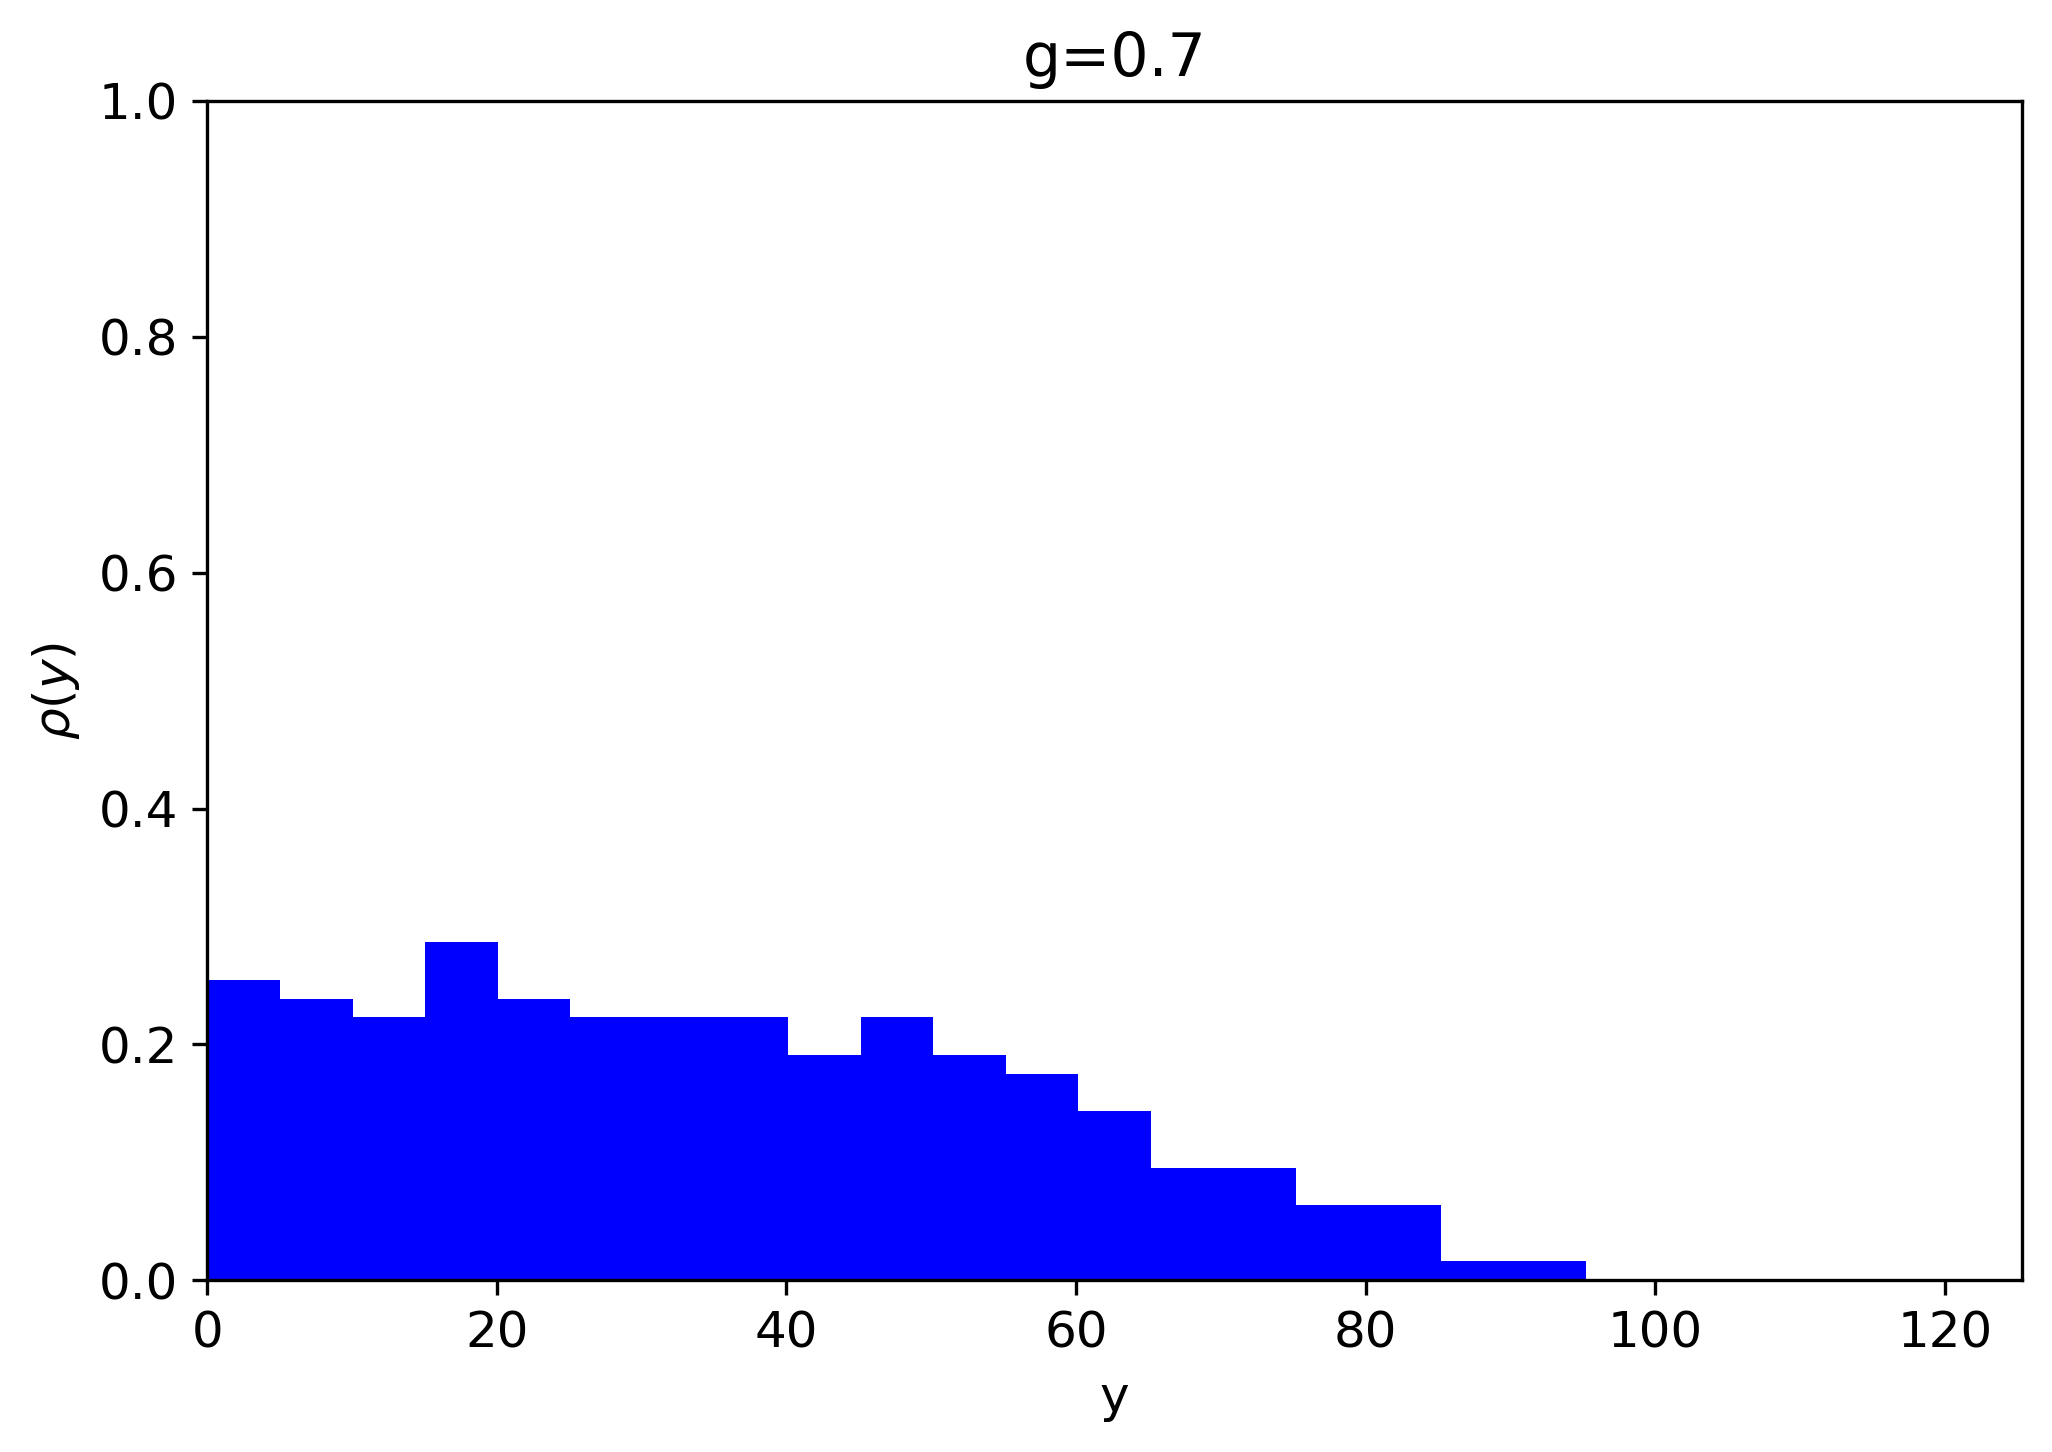

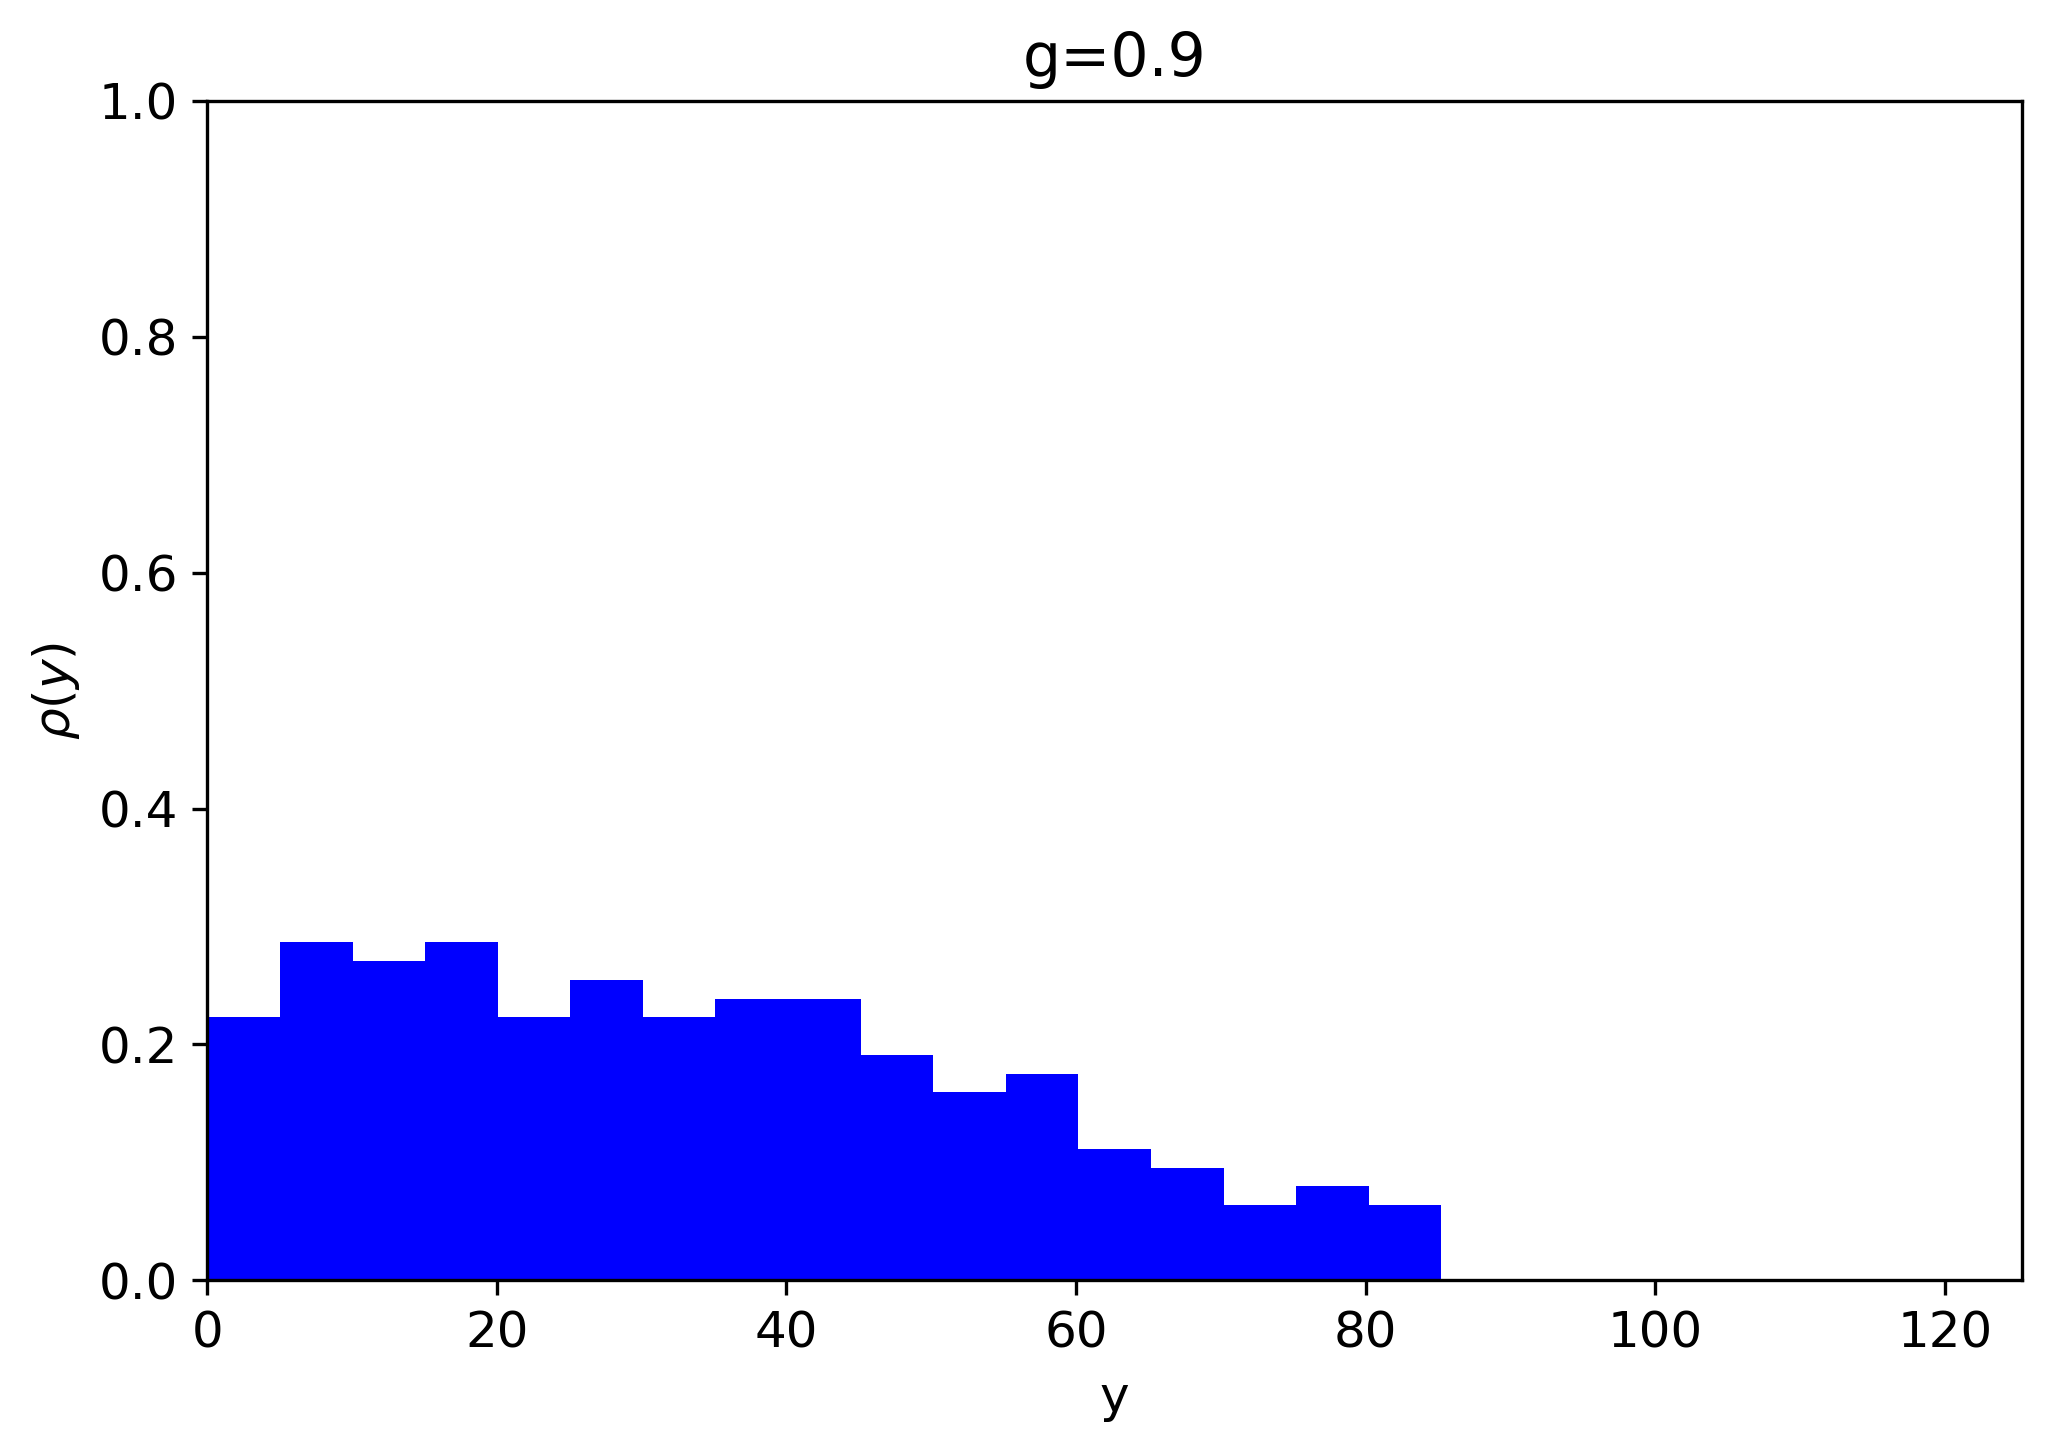

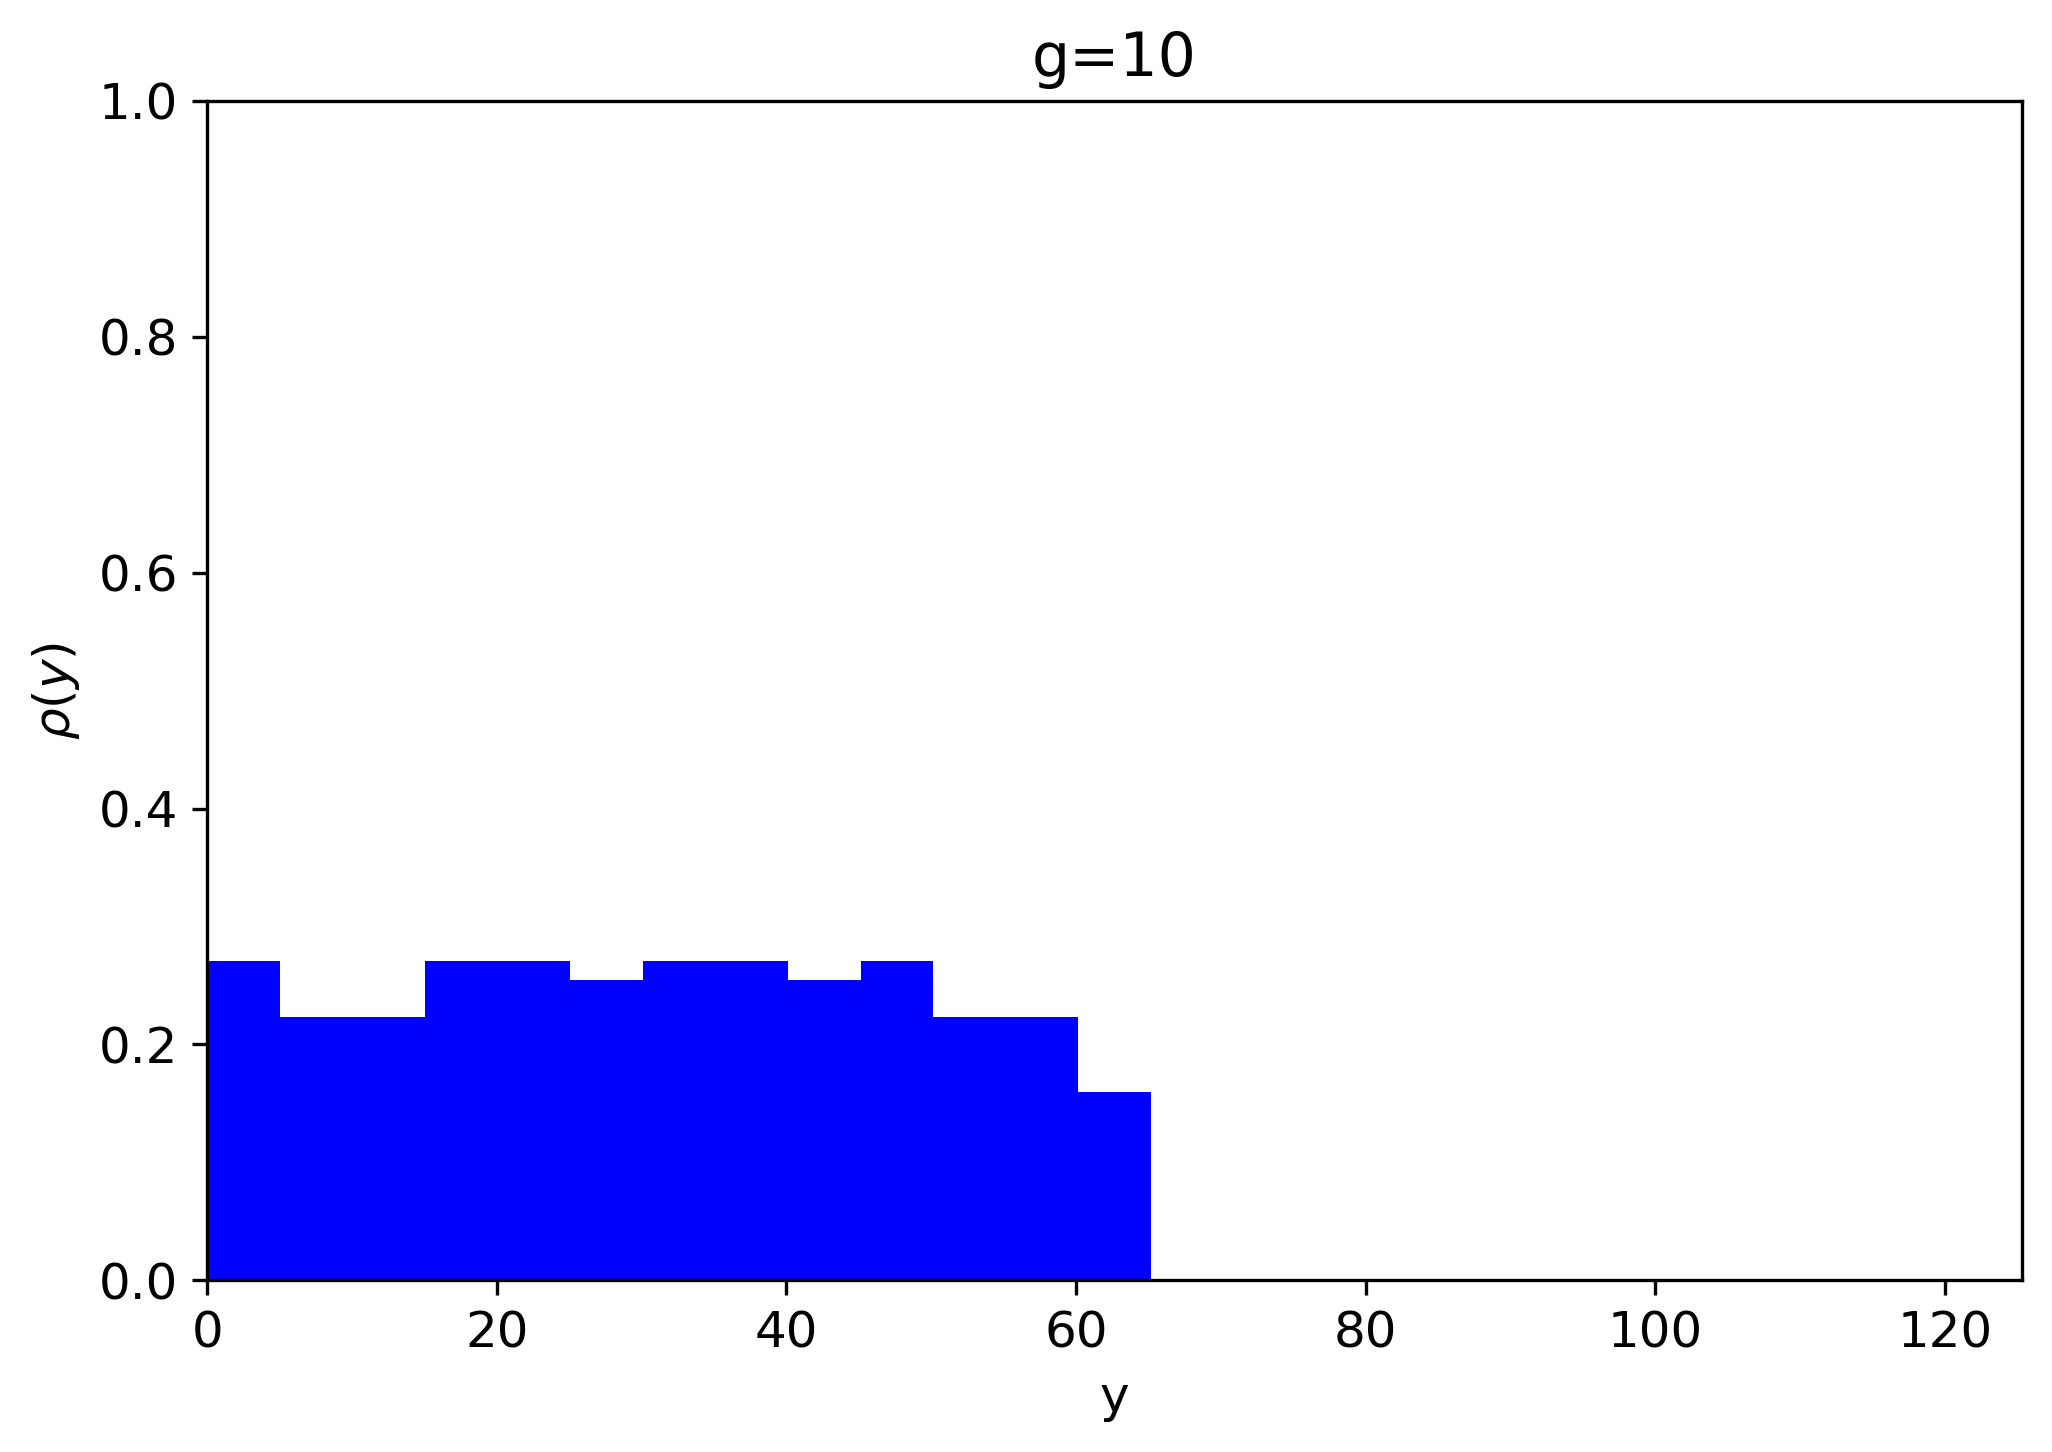

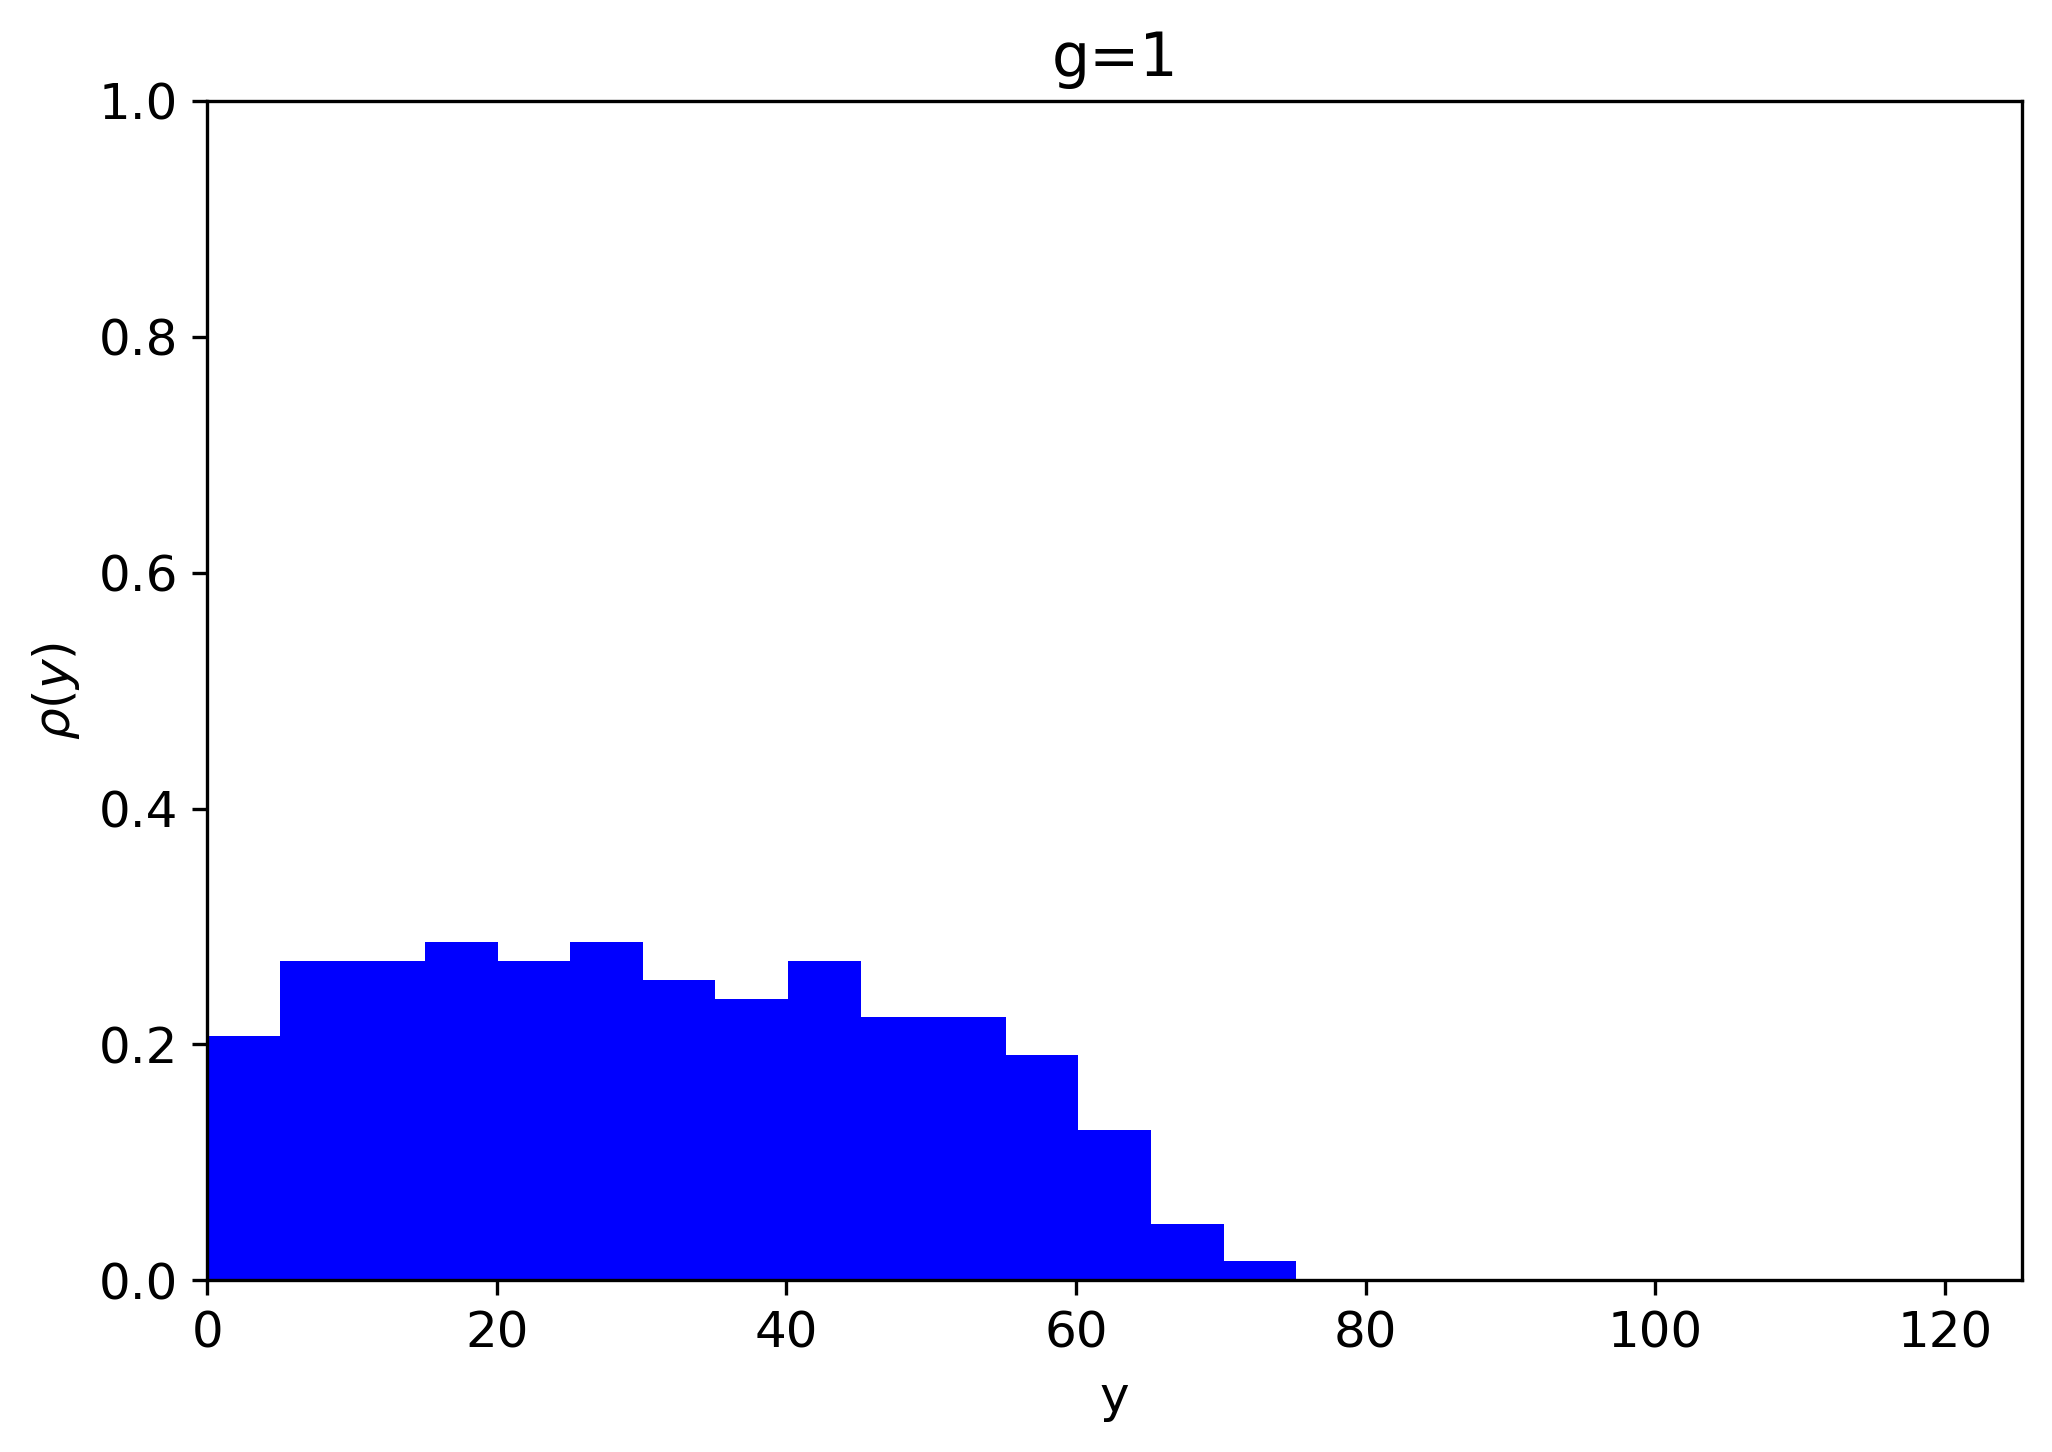

In [22]:
# --- Density profiles: one histogram figure per g ----------------------------
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re

# ---- User parameters ----
# If globals Lx/Ly exist, we can use them as fallback.
# Otherwise we will try to read them from the *_info.txt file.
bin_width = 5
normalize = True                          # divide by bin area Lx*bin_width
show_log = False                          # if True: plot ln rho(y) as bars (skips empty bins)
save_figs = False                         # set True to save PNGs next to the data files

# ---- Discover saved files automatically ----
files = sorted(glob.glob("sedimentation_g*_pos_final.txt"))

def parse_info_file(base):
    """Try to read Lx, Ly from the matching *_info.txt; return dict or {} if not found."""
    info_path = f"{base}_info.txt"
    out = {}
    if not os.path.exists(info_path):
        return out
    with open(info_path, "r") as f:
        text = f.read()
    # very forgiving regex
    mLx = re.search(r"Lx\s*=\s*([0-9.+-eE]+)", text)
    mLy = re.search(r"Ly\s*=\s*([0-9.+-eE]+)", text)
    if mLx: out["Lx"] = float(mLx.group(1))
    if mLy: out["Ly"] = float(mLy.group(1))
    return out

for fname in files:
    # Extract base and g value (e.g., "sedimentation_g0p1_pos_final.txt" -> base="sedimentation_g0p1")
    base = fname.replace("_pos_final.txt", "")
    label = base.split("g")[1].replace("p", ".")
    g_val = float(label)

    # Load positions
    pos = np.loadtxt(fname)
    y = pos[:, 1]

    # Try to get geometry from info file; fallback to current globals
    info = parse_info_file(base)
    Lx_use = info.get("Lx", Lx)
    Ly_use = info.get("Ly", Ly)

    # Binning
    nbins = max(1, int(np.floor(Ly_use / bin_width)))
    edges = np.linspace(0.0, Ly_use, nbins + 1)
    counts, _ = np.histogram(y, bins=edges)
    y_left = edges[:-1]
    bw = edges[1] - edges[0]   # actual bin width (nearly bin_width)

    # Normalize to number density ρ(y)
    if normalize:
        rho = counts.astype(float) / (bw * Lx_use)
        y_vals = rho
        y_label = r"$\rho(y)$"
    else:
        # normalized histogram (probability) if you prefer
        total = counts.sum()
        rho = counts.astype(float) / (total if total > 0 else 1.0)
        y_vals = rho
        y_label = r"Counts (normalized)"

    # Optional log-plot as bars (skip empty bins)
    if show_log:
        mask = y_vals > 0
        y_left_log = y_left[mask]
        y_vals_log = np.log(y_vals[mask])
        height_data = y_vals_log
        y_label = r"$\ln \rho(y)$" if normalize else r"$\ln \text{Counts}$"
    else:
        height_data = y_vals

    # --- Plot: one figure per g ---
    with plt.rc_context({'font.size': 12}):
        plt.figure(figsize=(7, 5), dpi=300)
        plt.bar(y_left if not show_log else (y_left_log),
                height_data,
                width=bw,
                align="edge",
                edgecolor="none",
                color="blue")
        plt.xlabel("y")
        plt.ylabel(y_label)
        plt.ylim(0,1)
        title = f"g={g_val:g}"
        plt.title(title)
        plt.xlim(0, Ly_use)
        plt.tight_layout()

        if save_figs:
            out_png = f"{base}_hist.png" if not show_log else f"{base}_hist_log.png"
            plt.savefig(out_png, dpi=300)
        plt.show()


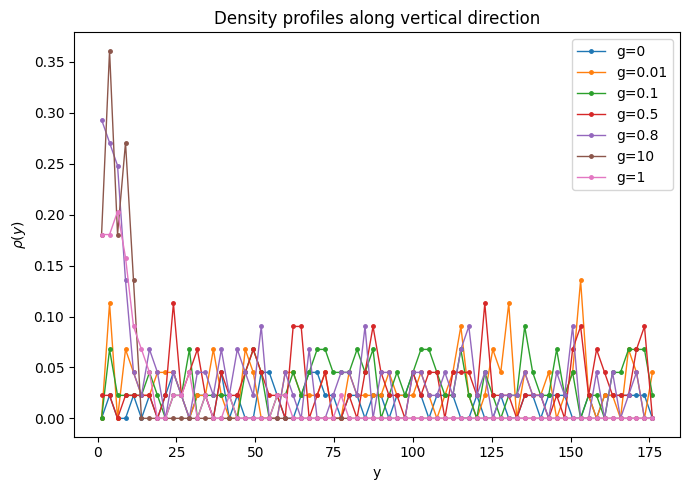

In [64]:
# --- Density profiles from saved final positions ------------------------------
import numpy as np
import matplotlib.pyplot as plt
import glob

# ---- User parameters ----
bin_width = max(2.5 * sigma, Ly / 80.0)   # choose σ < b << Ly for smoothness
normalize = True                          # divide by bin area Lx*bin_width
show_log = False                          # if True: also plot ln ρ(y)

# ---- Discover saved files automatically ----
files = sorted(glob.glob("sedimentation_g*_pos_final.txt"))

plt.figure(figsize=(7, 5))
for fname in files:
    # Extract g value from filename (e.g., "sedimentation_g0p1_pos_final.txt")
    label = fname.split("_pos_final.txt")[0].split("g")[1].replace("p", ".")
    g_val = float(label)

    # Load positions and compute histogram
    pos = np.loadtxt(fname)
    y = pos[:, 1]

    nbins = int(np.floor(Ly / bin_width))
    edges = np.linspace(0, Ly, nbins + 1)
    counts, _ = np.histogram(y, bins=edges)
    ycent = 0.5 * (edges[:-1] + edges[1:])

    if normalize:
        rho = counts / (bin_width * Lx)
    else:
        rho = counts / counts.sum()

    # Plot profile
    plt.plot(ycent, rho, marker="o", lw=1.0, ms=2.5, label=f"g={g_val:g}")

plt.xlabel("y")
plt.ylabel(r"$\rho(y)$" if not show_log else r"$\ln \rho(y)$")
plt.title("Density profiles along vertical direction")
plt.legend()
plt.tight_layout()
plt.show()
